In [1]:
import json
import os

from ost import io
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

data_dir = os.path.join("..", "data")
plot_dir = os.path.join("..", "data", "plots")

if not os.path.exists(data_dir):
    raise RuntimeError("You need to give me some data")
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
cred = (128.0/255,0.0,0.0)
cblue = (102.0/255,153.0/255,204.0/255)
cgreen = (102.0/255,148.0/255,0.0)
cpurple = (100.0/255,0.0,200.0/255)
corange = (255.0/255,123.0/255,0.0)

# color palette from Jay, originally from https://thenode.biologists.com/data-visualization-with-flying-colors/research/
#j_colors = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933', '#CC6677', '#882255', '#AA4499', '#DDDDDD']
# thats actually not Jay colors anymore. Its a color scheme from https://colorbrewer2.org
j_colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462']
# and thats from ggplot2
j_colors = ['#F8766D', '#B79F00','#00BA38','#00BFC4','#619CFF','#F564E3']

In [2]:
# data loading
df = pd.read_csv("../data/ema_global_scores.csv")
with open("../ema_targets.json", 'r') as fh:
    target_data = json.load(fh)
    
# target_data is a dict with key: target, value: list of target_files
# we're always gonna use the first target file
# The only targets where this will have real implications is
# H1171 and H1172 where we have several slightly different versions
target_data = {k: v[0] for k,v in target_data.items()}

# load group mapping
with open("../group_mappings.json", 'r') as fh:
    group_mappings = json.load(fh)

# manually add entry for baseline
group_mappings["AC"] = "AC"


In [3]:
# search for models for which we have no target values
no_score_df = df[(df["qs_best"].isnull()) | (df["gdtts"].isnull()) | (df["dockq_wave"].isnull())]
for m, t, qs_best, gdtts, dockq in zip(no_score_df["mdl"], no_score_df["trg"], no_score_df["qs_best"], no_score_df["gdtts"], no_score_df["dockq_wave"]):
    print(m, t, qs_best, gdtts, dockq)
print(no_score_df.shape)

# go to the raw json files
mdls_with_errors = list()

for mdl in no_score_df["mdl"]:
    json_filename = m+'_'
    if m.startswith('T'):
        json_filename += target_data[m[:5]+'o'].split('.')[0]+'.json'
    else:
        json_filename += target_data[m[:5]].split('.')[0]+'.json'
    json_path = "../data/scores/" + json_filename
    with open(json_path) as fh:
        data = json.load(fh)
    if "errors" in data and len(data["errors"]) > 0:
        mdls_with_errors.append(m)
        continue

print("Total N mdls:", len(set(df["mdl"])))
print("N mdls with errors:", len(mdls_with_errors))

# only keep the ones where we have all the own computed scores
df = df[(df["qs_best"].isnull()==False) | (df["gdtts"].isnull()==False) | (df["dockq_wave"].isnull()==False)]

H1111TS278_1 H1111.pdb nan nan nan
H1111TS215_5 H1111.pdb nan nan nan
H1111TS215_1 H1111.pdb nan nan nan
H1114TS239_1 H1114.pdb nan nan nan
H1114TS229_1 H1114.pdb nan nan nan
T1170TS360_3o T1170o.pdb nan nan nan
T1170TS360_4o T1170o.pdb nan nan nan
(7, 62)
Total N mdls: 11129
N mdls with errors: 7


In [4]:
# filter df - kick out models with different stoichiometry as target
# we're just going for chain count here... 
target_structure_dir = "../data/assembly_targets"
n_trg_chains = dict()
for f in os.listdir(target_structure_dir):
    ent = io.LoadPDB(os.path.join(target_structure_dir, f))
    n_trg_chains[f] = len(ent.chains)

df["n_trg_chains"] = [n_trg_chains[trg] for trg in df["trg"]]
df_filtered = df[df["n_mdl_chains"] == df["n_trg_chains"]]

# report kicked out models (T1192 gets kicked out completely, as the target has wrong stoichiometry)
mdls = set(df["mdl"])
filtered_mdls = set(df_filtered["mdl"])
assert(filtered_mdls.issubset(mdls))
kicked_out_mdls = mdls.difference(filtered_mdls)
kicked_out_mdls = sorted(list(kicked_out_mdls))
print(f"kicked out {len(kicked_out_mdls)} models:", kicked_out_mdls)
print(f"total models:", len(mdls))
print(f"remaining models:", len(filtered_mdls))
print(f"n targets:", len(set(df_filtered["trg"])))

df = df_filtered

residue A.CYS109 contains unknown atom OD1
residue A.CYS109 contains unknown atom OD2
residue A.CYS109 contains unknown atom OD3
residue B.CYS109 contains unknown atom OD1
residue B.CYS109 contains unknown atom OD2
residue B.CYS109 contains unknown atom OD3
residue C.CYS109 contains unknown atom OD1
residue C.CYS109 contains unknown atom OD2
residue C.CYS109 contains unknown atom OD3
residue D.CYS109 contains unknown atom OD1
residue D.CYS109 contains unknown atom OD2
residue D.CYS109 contains unknown atom OD3
residue E.CYS109 contains unknown atom OD1
residue E.CYS109 contains unknown atom OD2
residue E.CYS109 contains unknown atom OD3
residue F.CYS109 contains unknown atom OD1
residue F.CYS109 contains unknown atom OD2
residue F.CYS109 contains unknown atom OD3
residue G.CYS109 contains unknown atom OD1
residue G.CYS109 contains unknown atom OD2
residue G.CYS109 contains unknown atom OD3
residue H.CYS109 contains unknown atom OD1
residue H.CYS109 contains unknown atom OD2
residue H.C

kicked out 650 models: ['H1111TS037_1', 'H1111TS037_2', 'H1111TS037_3', 'H1111TS037_4', 'H1111TS037_5', 'H1111TS092_1', 'H1111TS097_2', 'H1111TS097_3', 'H1111TS097_4', 'H1111TS097_5', 'H1111TS169_1', 'H1111TS169_2', 'H1111TS169_3', 'H1111TS169_4', 'H1111TS169_5', 'H1111TS180_2', 'H1111TS180_3', 'H1111TS180_4', 'H1111TS180_5', 'H1111TS187_1', 'H1111TS187_2', 'H1111TS187_3', 'H1111TS187_4', 'H1111TS187_5', 'H1111TS227_1', 'H1111TS227_2', 'H1111TS227_3', 'H1111TS227_4', 'H1111TS227_5', 'H1111TS245_1', 'H1111TS245_2', 'H1111TS245_3', 'H1111TS245_4', 'H1111TS245_5', 'H1111TS333_1', 'H1111TS333_2', 'H1111TS333_3', 'H1111TS333_4', 'H1111TS333_5', 'H1111TS368_1', 'H1111TS368_2', 'H1111TS368_3', 'H1111TS368_4', 'H1111TS368_5', 'H1111TS385_1', 'H1111TS385_2', 'H1111TS385_3', 'H1111TS385_4', 'H1111TS385_5', 'H1111TS390_1', 'H1111TS390_2', 'H1111TS390_3', 'H1111TS390_4', 'H1111TS390_5', 'H1111TS423_2', 'H1111TS433_1', 'H1111TS433_2', 'H1111TS433_3', 'H1111TS433_4', 'H1111TS433_5', 'H1111TS441_1', 

Residue with number 53 contains a microheterogeneity. Everything but atoms for the residue 'ARG' will be ignored
Residue with number 53 contains a microheterogeneity. Everything but atoms for the residue 'ARG' will be ignored
Residue with number 53 contains a microheterogeneity. Everything but atoms for the residue 'ARG' will be ignored
Residue with number 53 contains a microheterogeneity. Everything but atoms for the residue 'ARG' will be ignored
residue E.CYS109 contains unknown atom OD1
residue E.CYS109 contains unknown atom OD2
residue E.CYS109 contains unknown atom OD3
residue F.CYS109 contains unknown atom OD1
residue F.CYS109 contains unknown atom OD2
residue F.CYS109 contains unknown atom OD3


In [5]:
groups = ['426', '168', '494', '126', '248', '266', '083', '282', '120', '468', '101', '234', '245', '002', '098', '298', '041', '158', '398', '121', '089', '169', '365', '283', '275', '086', 'AC']

In [6]:
# report how many datapoints we have per group
total_data_points = df.shape[0]
print("total datapoints:", total_data_points)
SCORE_data_points = dict()
for g in groups:
    n = df[df[g+"_SCORE"].isnull()==False].shape[0]
    print(f"group {g} SCORE datapoints: {n}")
    SCORE_data_points[g] = n

QSCORE_data_points = dict()
for g in groups:
    n = df[df[g+"_QSCORE"].isnull()==False].shape[0]
    print(f"group {g} QSCORE datapoints: {n}")
    QSCORE_data_points[g] = n

print()
print()
total_per_target_data_points = dict()
SCORE_per_target_data_points = {g: dict() for g in groups}
QSCORE_per_target_data_points = {g: dict() for g in groups}
for trg, trg_file in target_data.items():
    sub_df = df[df["trg"]==trg_file]
    total_per_target_data_points[trg] = sub_df.shape[0]
    print(f"target {trg} datapoints: {total_per_target_data_points[trg]}")
    for g in groups:
        n = sub_df[sub_df[g+"_SCORE"].isnull()==False].shape[0]
        SCORE_per_target_data_points[g][trg] = n
        print(f"group {g} SCORE datapoints: {n}")
        n = sub_df[sub_df[g+"_QSCORE"].isnull()==False].shape[0]
        QSCORE_per_target_data_points[g][trg] = n
        print(f"group {g} QSCORE datapoints: {n}")
    print("\n\n")

total datapoints: 10472
group 426 SCORE datapoints: 9563
group 168 SCORE datapoints: 9563
group 494 SCORE datapoints: 10162
group 126 SCORE datapoints: 14
group 248 SCORE datapoints: 10191
group 266 SCORE datapoints: 10460
group 083 SCORE datapoints: 10460
group 282 SCORE datapoints: 8859
group 120 SCORE datapoints: 10466
group 468 SCORE datapoints: 9563
group 101 SCORE datapoints: 0
group 234 SCORE datapoints: 4833
group 245 SCORE datapoints: 8998
group 002 SCORE datapoints: 10162
group 098 SCORE datapoints: 9888
group 298 SCORE datapoints: 10472
group 041 SCORE datapoints: 10459
group 158 SCORE datapoints: 10014
group 398 SCORE datapoints: 10472
group 121 SCORE datapoints: 10160
group 089 SCORE datapoints: 9855
group 169 SCORE datapoints: 9722
group 365 SCORE datapoints: 5944
group 283 SCORE datapoints: 10472
group 275 SCORE datapoints: 10133
group 086 SCORE datapoints: 10469
group AC SCORE datapoints: 10450
group 426 QSCORE datapoints: 9563
group 168 QSCORE datapoints: 9563
group 49

group 041 SCORE datapoints: 162
group 041 QSCORE datapoints: 162
group 158 SCORE datapoints: 162
group 158 QSCORE datapoints: 162
group 398 SCORE datapoints: 162
group 398 QSCORE datapoints: 162
group 121 SCORE datapoints: 162
group 121 QSCORE datapoints: 162
group 089 SCORE datapoints: 162
group 089 QSCORE datapoints: 0
group 169 SCORE datapoints: 162
group 169 QSCORE datapoints: 0
group 365 SCORE datapoints: 162
group 365 QSCORE datapoints: 0
group 283 SCORE datapoints: 162
group 283 QSCORE datapoints: 0
group 275 SCORE datapoints: 152
group 275 QSCORE datapoints: 162
group 086 SCORE datapoints: 162
group 086 QSCORE datapoints: 162
group AC SCORE datapoints: 162
group AC QSCORE datapoints: 162



target T1115o datapoints: 134
group 426 SCORE datapoints: 133
group 426 QSCORE datapoints: 133
group 168 SCORE datapoints: 133
group 168 QSCORE datapoints: 133
group 494 SCORE datapoints: 134
group 494 QSCORE datapoints: 134
group 126 SCORE datapoints: 0
group 126 QSCORE datapoints: 0
group 

group 121 SCORE datapoints: 141
group 121 QSCORE datapoints: 141
group 089 SCORE datapoints: 141
group 089 QSCORE datapoints: 141
group 169 SCORE datapoints: 142
group 169 QSCORE datapoints: 0
group 365 SCORE datapoints: 142
group 365 QSCORE datapoints: 0
group 283 SCORE datapoints: 142
group 283 QSCORE datapoints: 0
group 275 SCORE datapoints: 140
group 275 QSCORE datapoints: 142
group 086 SCORE datapoints: 142
group 086 QSCORE datapoints: 142
group AC SCORE datapoints: 142
group AC QSCORE datapoints: 142



target H1140 datapoints: 319
group 426 SCORE datapoints: 319
group 426 QSCORE datapoints: 319
group 168 SCORE datapoints: 319
group 168 QSCORE datapoints: 319
group 494 SCORE datapoints: 307
group 494 QSCORE datapoints: 307
group 126 SCORE datapoints: 0
group 126 QSCORE datapoints: 0
group 248 SCORE datapoints: 319
group 248 QSCORE datapoints: 319
group 266 SCORE datapoints: 319
group 266 QSCORE datapoints: 319
group 083 SCORE datapoints: 319
group 083 QSCORE datapoints: 319
group

group 101 QSCORE datapoints: 291
group 234 SCORE datapoints: 0
group 234 QSCORE datapoints: 0
group 245 SCORE datapoints: 291
group 245 QSCORE datapoints: 283
group 002 SCORE datapoints: 258
group 002 QSCORE datapoints: 258
group 098 SCORE datapoints: 283
group 098 QSCORE datapoints: 0
group 298 SCORE datapoints: 291
group 298 QSCORE datapoints: 0
group 041 SCORE datapoints: 291
group 041 QSCORE datapoints: 291
group 158 SCORE datapoints: 291
group 158 QSCORE datapoints: 283
group 398 SCORE datapoints: 291
group 398 QSCORE datapoints: 291
group 121 SCORE datapoints: 258
group 121 QSCORE datapoints: 258
group 089 SCORE datapoints: 291
group 089 QSCORE datapoints: 283
group 169 SCORE datapoints: 283
group 169 QSCORE datapoints: 0
group 365 SCORE datapoints: 0
group 365 QSCORE datapoints: 0
group 283 SCORE datapoints: 291
group 283 QSCORE datapoints: 0
group 275 SCORE datapoints: 287
group 275 QSCORE datapoints: 287
group 086 SCORE datapoints: 291
group 086 QSCORE datapoints: 291
group AC

group 248 QSCORE datapoints: 283
group 266 SCORE datapoints: 283
group 266 QSCORE datapoints: 283
group 083 SCORE datapoints: 283
group 083 QSCORE datapoints: 283
group 282 SCORE datapoints: 283
group 282 QSCORE datapoints: 0
group 120 SCORE datapoints: 283
group 120 QSCORE datapoints: 0
group 468 SCORE datapoints: 283
group 468 QSCORE datapoints: 283
group 101 SCORE datapoints: 0
group 101 QSCORE datapoints: 283
group 234 SCORE datapoints: 0
group 234 QSCORE datapoints: 0
group 245 SCORE datapoints: 0
group 245 QSCORE datapoints: 0
group 002 SCORE datapoints: 283
group 002 QSCORE datapoints: 283
group 098 SCORE datapoints: 283
group 098 QSCORE datapoints: 0
group 298 SCORE datapoints: 283
group 298 QSCORE datapoints: 0
group 041 SCORE datapoints: 283
group 041 QSCORE datapoints: 283
group 158 SCORE datapoints: 283
group 158 QSCORE datapoints: 283
group 398 SCORE datapoints: 283
group 398 QSCORE datapoints: 283
group 121 SCORE datapoints: 283
group 121 QSCORE datapoints: 283
group 089 

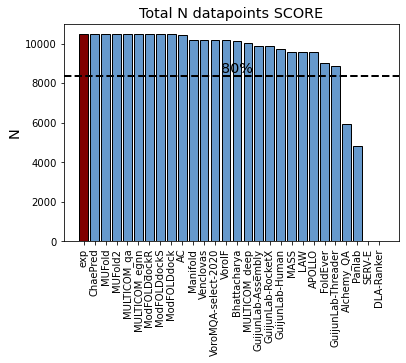

In [7]:
# plot data situation on full datapoints (SCORE)

# the reference...
plt.bar([0], [total_data_points], color=cred, linewidth=1.0, edgecolor='k')

# data from groups
tmp = [(SCORE_data_points[g],g) for g in groups]
tmp.sort(reverse=True)
sorted_data_points = [x[0] for x in tmp]
sorted_groups = [x[1] for x in tmp]
sorted_groups_names = [group_mappings[x] for x in sorted_groups]
x = list(range(1, len(sorted_groups)+1))
plt.bar(x, sorted_data_points, color=cblue, linewidth=1.0, edgecolor='k')

# plot 80% line
plt.axhline(0.8*total_data_points, linestyle='--', linewidth=2.0, color='k')
plt.text((len(sorted_data_points)+1)/2, 0.8*total_data_points,"80%", fontsize="x-large", verticalalignment="bottom",horizontalalignment="center")

plt.ylabel("N", fontsize="x-large")
plt.title("Total N datapoints SCORE", fontsize="x-large")
plt.xticks([0] + x, ["exp"] + sorted_groups_names, rotation=90)
plt.savefig(os.path.join(plot_dir, "global_data_points_SCORE.png"), dpi=300, bbox_inches="tight")

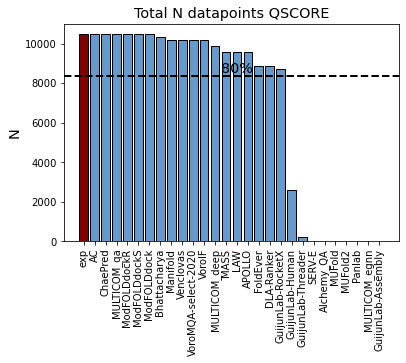

In [8]:
# plot data situation on full datapoints (QSCORE)

# the reference...
plt.bar([0], [total_data_points], color=cred, linewidth=1.0, edgecolor='k')

# data from groups
tmp = [(QSCORE_data_points[g],g) for g in groups]
tmp.sort(reverse=True)
sorted_data_points = [x[0] for x in tmp]
sorted_groups = [x[1] for x in tmp]
sorted_groups_names = [group_mappings[x] for x in sorted_groups]
x = list(range(1, len(sorted_groups)+1))
plt.bar(x, sorted_data_points, color=cblue, linewidth=1.0, edgecolor='k')

# plot 80% line
plt.axhline(0.8*total_data_points, linestyle='--', linewidth=2.0, color='k')
plt.text((len(sorted_data_points)+1)/2, 0.8*total_data_points,"80%", fontsize="x-large", verticalalignment="bottom",horizontalalignment="center")

plt.ylabel("N", fontsize="x-large")
plt.title("Total N datapoints QSCORE", fontsize="x-large")
plt.xticks([0] + x, ["exp"] + sorted_groups_names, rotation=90)
plt.savefig(os.path.join(plot_dir, "global_data_points_QSCORE.png"), dpi=300, bbox_inches="tight")

groups considered for further SCORE evaluation: ['AC', '494', '398', '298', '283', '275', '266', '121', '120', '086', '083', '041', '002', '248', '158', '089', '169', '098', '468', '426', '168', '282', '245']


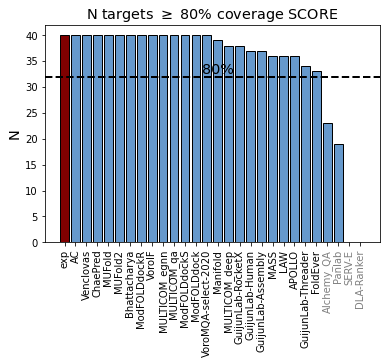

In [9]:
# plot data situation on a per-target basis SCORE

# the reference...
N = sum([1 for x in total_per_target_data_points.values() if x > 0])
plt.bar([0], [N], color=cred, linewidth=1.0, edgecolor='k')

# data from groups - count how many targets have > 80% of datapoints
counts = {g: 0 for g in groups}
for g in groups:
    for trg, tot in total_per_target_data_points.items():
        if tot == 0:
            fraction = 0.0 # happens for T1192o
        else:
            fraction = float(SCORE_per_target_data_points[g][trg])/tot
        if fraction > 0.8:
            counts[g] += 1

tmp = [(counts[g],g) for g in groups]
tmp.sort(reverse=True)
sorted_data_points = [x[0] for x in tmp]
sorted_groups = [x[1] for x in tmp]
sorted_groups_names = [group_mappings[x] for x in sorted_groups]
x = list(range(1, len(sorted_groups)+1))
plt.bar(x, sorted_data_points, color=cblue, linewidth=1.0, edgecolor='k')

# plot 80% line
plt.axhline(0.8*N, linestyle='--', linewidth=2.0, color='k')
plt.text((len(sorted_data_points)+1)/2, 0.8*N,"80%", fontsize="x-large", verticalalignment="bottom",horizontalalignment="center")

sorted_groups_names = ["exp"] + sorted_groups_names
tick_colors = ['k']
for data_point in sorted_data_points:
    if data_point < 0.8*N:
        tick_colors.append('0.5')
    else:
        tick_colors.append('k')

plt.xticks([0] + x, sorted_groups_names, rotation=90)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), tick_colors):
    ticklabel.set_color(tickcolor)

plt.ylabel("N", fontsize="x-large")
plt.title(r"N targets $\geq$ 80% coverage SCORE", fontsize="x-large")
plt.savefig(os.path.join(plot_dir, "global_data_points_per_target_SCORE.png"), dpi=300, bbox_inches="tight")

# And here's what we want for further processing
SCORE_eval_groups = [g for g,c in zip(sorted_groups, sorted_data_points) if c >= 0.8*N]
print("groups considered for further SCORE evaluation:", SCORE_eval_groups)

groups considered for further QSCORE evaluation: ['AC', '494', '398', '275', '266', '121', '086', '083', '041', '002', '248', '158', '468', '426', '168', '245', '089', '101']


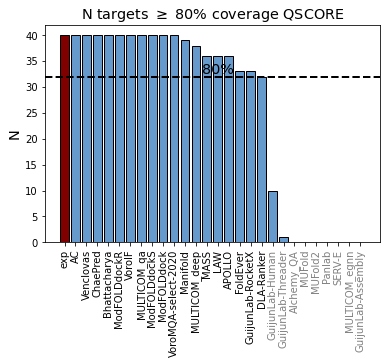

In [10]:
# plot data situation on a per-target basis QSCORE

# the reference...
N = sum([1 for x in total_per_target_data_points.values() if x > 0])
plt.bar([0], [N], color=cred, linewidth=1.0, edgecolor='k')

# data from groups - count how many targets have > 80% of datapoints
counts = {g: 0 for g in groups}
for g in groups:
    for trg, tot in total_per_target_data_points.items():
        if tot == 0:
            fraction = 0.0 # happens for T1192o
        else:
            fraction = float(QSCORE_per_target_data_points[g][trg])/tot
        if fraction > 0.8:
            counts[g] += 1

tmp = [(counts[g],g) for g in groups]
tmp.sort(reverse=True)
sorted_data_points = [x[0] for x in tmp]
sorted_groups = [x[1] for x in tmp]
sorted_groups_names = [group_mappings[x] for x in sorted_groups]
x = list(range(1, len(sorted_groups)+1))
plt.bar(x, sorted_data_points, color=cblue, linewidth=1.0, edgecolor='k')

# plot 80% line
plt.axhline(0.8*N, linestyle='--', linewidth=2.0, color='k')
plt.text((len(sorted_data_points)+1)/2, 0.8*N,"80%", fontsize="x-large", verticalalignment="bottom",horizontalalignment="center")

sorted_groups_names = ["exp"] + sorted_groups_names
tick_colors = ['k']
for data_point in sorted_data_points:
    if data_point < 0.8*N:
        tick_colors.append('0.5')
    else:
        tick_colors.append('k')

plt.xticks([0] + x, sorted_groups_names, rotation=90)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), tick_colors):
    ticklabel.set_color(tickcolor)

plt.ylabel("N", fontsize="x-large")
plt.title(r"N targets $\geq$ 80% coverage QSCORE", fontsize="x-large")
plt.savefig(os.path.join(plot_dir, "global_data_points_per_target_QSCORE.png"), dpi=300, bbox_inches="tight")

# And here's what we want for further processing
QSCORE_eval_groups = [g for g,c in zip(sorted_groups, sorted_data_points) if c >= 0.8*N]
print("groups considered for further QSCORE evaluation:", QSCORE_eval_groups)

In [11]:
print(len(SCORE_eval_groups))
print(len(QSCORE_eval_groups))

23
18


In [12]:
# evaluation metrics
def adaptive_rocauc(df, target, pred):
    """ Returns ROC AUC with an adaptive class threshold
    
    Adaptive in a sense that the top quantile according target
    is considered positive.
    """
    thresh = df[target].quantile(0.75)
    sub_df = df[(df[target].isnull() == False) & (df[pred].isnull() == False)]
    target_classes = [int(x>thresh) for x in sub_df[target]]
    return max(0.5, roc_auc_score(target_classes, sub_df[pred]))

def pearson_corr(df, target, pred):
    """ Returns pearson correlation
    """
    if df[pred].nunique() == 1:
        return 0.0 # group 168 thinks its funny to return the same value for all models in a target
    return df[target].corr(df[pred], method="pearson")

def spearman_corr(df, target, pred):
    """ Returns spearman correlation
    """
    if df[pred].nunique() == 1:
        return 0.0 # group 168...
    return df[target].corr(df[pred], method="spearman")

def diff_to_best(df, target, pred):
    best_score = df[target].max()
    selected_score = df[target][df[pred].idxmax()]
    return best_score - selected_score


In [13]:
def per_target_eval(df, target, eval_groups, score_or_qscore,
                    target_data, filter_target, filter_target_thresh,
                    metrics={"pearson_r": pearson_corr,
                             "spearman_r": spearman_corr,
                             "roc_auc": adaptive_rocauc,
                             "loss": diff_to_best}):
    """ Returns DataFrame with one row per target
    
    For each target, each group is evaluated against specified metrics
    (default: pearson_r, spearman_r, roc_auc, loss)
    
    So let's say you have one target (x) and one group (y), you'll get the 
    following columns: x, y_pearson_r, y_spearman_r, y_roc_auc, y_loss
    
    :param df: The overall per-model DataFrame
    :type df: :class:`DataFrame`
    :param target: The target value, e.g. tm_score, gdtts, qs_best, dockq_wave
    :type target: :class:`str`
    :param eval_groups: List of groups that are evaluated (y in example above)
    :type eval_groups: :class:`list` of :class:`str`
    :param score_or_qscore: 'SCORE' or 'QSCORE'
    :type score_or_qscore: :class:`str`
    :param target_data: Dictionary used in overall evaluation, i.e. trg name as key
                        and respective target file as value
    :type target_data: :class:`dict`
    :param filter_target: Target value used for filtering, i.e. target will be skipped if 
                          no model has the respective value above *filter_target_thresh*
                          (e.g. tm_score, qs_best, etc.)
    :type filter_target: :class:`str`
    :param filter_target_thresh: Threshold for specified *filter_target*
    :type filter_target_tresh: :class:`float`
    :param metrics: Evaluation metrics... shouldn't be changed...
    :type metrics: :class:`dict`
    """
    data = {"trg": list()}
    for g in eval_groups:
        for m in metrics.keys():
            data[g + "_" + m] = list()
    for trg, trg_file in target_data.items():
        sub_df = df[df["trg"] == trg_file]
        # skip targets that have been filtered out completely in preprocessing (happens for T1192o)
        if sub_df.shape[0] == 0:
            print(f"no data for {trg}... skip...")
            continue
        # per-target evaluation only assesses targets which fulfill very crude
        # quality filter, e.g. max TMscore of any of the models > 0.6
        if sub_df[filter_target].max() < filter_target_thresh:
            print("skip trg", trg)
            continue
        data["trg"].append(trg)
        for g in eval_groups:
            n_exp = sub_df.shape[0]
            n_pred = sub_df[sub_df[g+f"_{score_or_qscore}"].isnull()==False].shape[0]
            if float(n_pred)/n_exp < 0.8:
                # not enough predictions for g
                for m in metrics.keys():
                    data[g + "_" + m].append(None)
            else:
                for m,f in metrics.items():
                    data[g + "_" + m].append(f(sub_df, target, f"{g}_{score_or_qscore}"))
    return pd.DataFrame.from_dict(data)

def per_group_eval(per_target_df, eval_groups,
                   metrics=["pearson_r", "spearman_r", "roc_auc", "loss"]):
    """ Takes per_target evaluation with respect to one target value (e.g. tm_score)
    and returns DataFrame with per group averages
    
    So lets say you have one group x, you'll get a DataFrame with the following columns:
    x, pearson_r, spearman_r, roc_auc, loss where the evaluation metrics represent the
    per-target averages.
    
    :param per_target_df: Return value of :func:`per_target_eval`
    :type per_target_df: :class:`DataFrame`
    :param eval_groups: List of groups that are evaluated, must be consistent with what
                        you give :func:`per_target_eval`
    :type eval_groups: :class:`list` of :class:`str`
    :param metrics: Metrics you evaluate with, must be consistent with what you give
                    :func:`per_target_eval`
    :type metrics: :class:`list` of :class:`str`
    """
    data = {"group": list()}
    for m in metrics:
        data[m] = list()
    for g in eval_groups:
        data["group"].append(g)
        for m in metrics:
            data[m].append(per_target_df[f"{g}_{m}"].mean())
    return pd.DataFrame.from_dict(data)


In [14]:
# prepare SCORE data
tm_per_target_df = per_target_eval(df, "tm_score", SCORE_eval_groups, "SCORE", target_data, "tm_score", 0.6)
tm_per_group_df = per_group_eval(tm_per_target_df, SCORE_eval_groups)
gdtts_per_target_df = per_target_eval(df, "gdtts", SCORE_eval_groups, "SCORE", target_data, "tm_score", 0.6)
gdtts_per_group_df = per_group_eval(gdtts_per_target_df, SCORE_eval_groups)

from scipy.stats import zscore
z_tm_per_group_df = tm_per_group_df.copy()
numeric_cols = z_tm_per_group_df.select_dtypes(include=[np.number]).columns
for nc in numeric_cols:
    z_tm_per_group_df[nc] = zscore(z_tm_per_group_df[nc])

z_gdtts_per_group_df = gdtts_per_group_df.copy()
numeric_cols = z_gdtts_per_group_df.select_dtypes(include=[np.number]).columns
for nc in numeric_cols:
    z_gdtts_per_group_df[nc] = zscore(z_gdtts_per_group_df[nc])

# reverse Z-scores of loss columns (low is good)
z_tm_per_group_df["loss"] = (-1.0) * z_tm_per_group_df["loss"]
z_gdtts_per_group_df["loss"] = (-1.0) * z_gdtts_per_group_df["loss"]

# don't punish for abysmal performance => set negative z-scores to 0.0
num = z_tm_per_group_df._get_numeric_data()
num[num < 0] = 0
num = z_gdtts_per_group_df._get_numeric_data()
num[num < 0] = 0

skip trg T1176o
no data for T1192o... skip...
skip trg T1176o
no data for T1192o... skip...


In [15]:
# prepare QSCORE data
qs_per_target_df = per_target_eval(df, "qs_best", QSCORE_eval_groups, "QSCORE", target_data, "qs_best", 0.6)
qs_per_group_df = per_group_eval(qs_per_target_df, QSCORE_eval_groups)
dockq_per_target_df = per_target_eval(df, "dockq_wave", QSCORE_eval_groups, "QSCORE", target_data, "qs_best", 0.6)
dockq_per_group_df = per_group_eval(dockq_per_target_df, QSCORE_eval_groups)

# compute Z-scores
z_qs_per_group_df = qs_per_group_df.copy()
numeric_cols = z_qs_per_group_df.select_dtypes(include=[np.number]).columns
for nc in numeric_cols:
    z_qs_per_group_df[nc] = zscore(z_qs_per_group_df[nc])

z_dockq_per_group_df = dockq_per_group_df.copy()
numeric_cols = z_dockq_per_group_df.select_dtypes(include=[np.number]).columns
for nc in numeric_cols:
    z_dockq_per_group_df[nc] = zscore(z_dockq_per_group_df[nc])

# reverse Z-scores of loss columns (low is good)
z_qs_per_group_df["loss"] = (-1.0) * z_qs_per_group_df["loss"]
z_dockq_per_group_df["loss"] = (-1.0) * z_dockq_per_group_df["loss"]

# don't punish for abysmal performance => set negative z-scores to 0.0
num = z_qs_per_group_df._get_numeric_data()
num[num < 0] = 0
num = z_dockq_per_group_df._get_numeric_data()
num[num < 0] = 0

skip trg T1176o
no data for T1192o... skip...
skip trg T1176o
no data for T1192o... skip...


In [16]:
# dump tables for external analysis

tm_to_dump = tm_per_group_df.copy()
tm_to_dump["group"] = [group_mappings[g] for g in tm_to_dump["group"]]
tm_to_dump.to_csv("../data/tables/SCORE_tables/TMscore_per_target_averages.csv")

gdtts_to_dump = gdtts_per_group_df.copy()
gdtts_to_dump["group"] = [group_mappings[g] for g in gdtts_to_dump["group"]]
assert(tm_to_dump["group"].equals(gdtts_to_dump["group"]))
gdtts_to_dump.to_csv("../data/tables/SCORE_tables/oligo-GDTTS_per_target_averages.csv")


qs_to_dump = qs_per_group_df.copy()
qs_to_dump["group"] = [group_mappings[g] for g in qs_to_dump["group"]]
qs_to_dump.to_csv("../data/tables/QSCORE_tables/QS-best_per_target_averages.csv")

dockq_to_dump = dockq_per_group_df.copy()
dockq_to_dump["group"] = [group_mappings[g] for g in dockq_to_dump["group"]]
assert(qs_to_dump["group"].equals(dockq_to_dump["group"]))
dockq_to_dump.to_csv("../data/tables/QSCORE_tables/DockQ-wave_per_target_averages.csv")

# now the per-target tables
tm_per_target_df.to_csv("../data/tables/SCORE_tables/TMscore_per_target.csv")
gdtts_per_target_df.to_csv("../data/tables/SCORE_tables/oligo-GDTTS_per_target.csv")
qs_per_target_df.to_csv("../data/tables/QSCORE_tables/QS-best_per_target.csv")
dockq_per_target_df.to_csv("../data/tables/QSCORE_tables/DockQ-wave_per_target.csv")


In [17]:
# dump tables for predictioncenter results
def predictioncenter_table(per_target_df, eval_groups, group_mapping, 
                           metrics=["pearson_r", "spearman_r", "roc_auc", "loss"]):
    """ Takes per target evaluation and returns Andriy approved dataframe
    
    :param per_target_df: Return value of :func:`per_target_eval`
    :type per_target_df: :class:`DataFrame`
    :param eval_groups: List of groups that are evaluated, must be consistent with what
                        you give :func:`per_target_eval`
    :type eval_groups: :class:`list` of :class:`str`
    :param group_mapping: Mapping where you can request group name given group id from *eval_groups*
    :type group_mapping: :class:`dict`
    :param metrics: Metrics you evaluate with, must be consistent with what you give
                    :func:`per_target_eval`
    :type metrics: :class:`list` of :class:`str`
    """
    data = {"target": list(),
            "group_id": list(),
            "group_name": list()}
    for m in metrics:
        data[m] = list()
        
    # do the average
    for g in eval_groups:
        data["group_id"].append(g)
        data["group_name"].append(group_mapping[g])
        data["target"].append("avg")
        for m in metrics:
            data[m].append(per_target_df[f"{g}_{m}"].mean())
    
    # do per-target
    for t in per_target_df["trg"]:
        sub_df = per_target_df[per_target_df["trg"]==t]
        for g in eval_groups:
            data["group_id"].append(g)
            data["group_name"].append(group_mapping[g])
            data["target"].append(t)
            for m in metrics:
                data[m].append(sub_df[f"{g}_{m}"].iat[0])

    return pd.DataFrame.from_dict(data)

In [18]:
tm_predictioncenter_df = predictioncenter_table(tm_per_target_df, SCORE_eval_groups, group_mappings)
tm_predictioncenter_df.to_csv("../data/tables/SCORE_tables/predictioncenter_TMscore.csv")

gdtts_predictioncenter_df = predictioncenter_table(gdtts_per_target_df, SCORE_eval_groups, group_mappings)
gdtts_predictioncenter_df.to_csv("../data/tables/SCORE_tables/predictioncenter_oligo-GDTTS.csv")

qs_predictioncenter_df = predictioncenter_table(qs_per_target_df, QSCORE_eval_groups, group_mappings)
qs_predictioncenter_df.to_csv("../data/tables/QSCORE_tables/predictioncenter_QS-best.csv")

dockq_predictioncenter_df = predictioncenter_table(dockq_per_target_df, QSCORE_eval_groups, group_mappings)
dockq_predictioncenter_df.to_csv("../data/tables/QSCORE_tables/predictioncenter_DockQ-wave.csv")

../data/plots


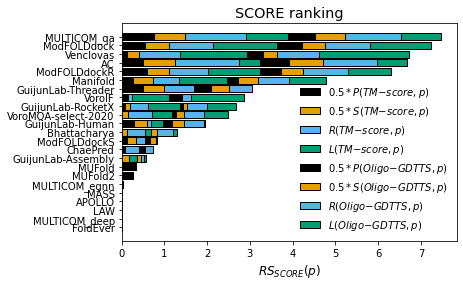

In [19]:
# do SCORE plot

# apply the magic formula 
final_score_tm = 0.5*z_tm_per_group_df["pearson_r"] + 0.5*z_tm_per_group_df["spearman_r"] + z_tm_per_group_df["roc_auc"] + z_tm_per_group_df["loss"]
final_score_gdtts = 0.5*z_gdtts_per_group_df["pearson_r"] + 0.5*z_gdtts_per_group_df["spearman_r"] + z_gdtts_per_group_df["roc_auc"] + z_gdtts_per_group_df["loss"]
final_score = np.add(final_score_tm, final_score_gdtts)

# sort tables by final score
z_tm_per_group_df["final_score"] = final_score
z_gdtts_per_group_df["final_score"] = final_score
z_tm_per_group_df.sort_values("final_score", inplace=True)
z_gdtts_per_group_df.sort_values("final_score", inplace=True)


# stolen from http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plt.clf()
y = list(range(z_tm_per_group_df.shape[0]))

left = np.array([0] * len(y))
plt.barh(y, 0.5*z_tm_per_group_df["pearson_r"], left=left, color=colors[0], linewidth=1.0, edgecolor='k', label="$0.5*P(TM\mathrm{-}score,p)$")

left = np.add(left, 0.5*z_tm_per_group_df["pearson_r"])
plt.barh(y, 0.5*z_tm_per_group_df["spearman_r"], left=left, color=colors[1], linewidth=1.0, edgecolor='k', label="$0.5*S(TM\mathrm{-}score,p)$")

left = np.add(left, 0.5*z_tm_per_group_df["spearman_r"])
plt.barh(y, z_tm_per_group_df["roc_auc"], left=left, color=colors[2], linewidth=1.0, edgecolor='k', label="$R(TM\mathrm{-}score,p)$")

left = np.add(left, z_tm_per_group_df["roc_auc"])
plt.barh(y, z_tm_per_group_df["loss"], left=left, color=colors[3], linewidth=1.0, edgecolor='k', label="$L(TM\mathrm{-}score,p)$")

left = np.add(left, z_tm_per_group_df["loss"])
plt.barh(y, 0.5*z_gdtts_per_group_df["pearson_r"], left=left, color=colors[0], linewidth=1.0, edgecolor='k', label="$0.5*P(Oligo\mathrm{-}GDTTS,p)$")

left = np.add(left, 0.5*z_gdtts_per_group_df["pearson_r"])
plt.barh(y, 0.5*z_gdtts_per_group_df["spearman_r"], left=left, color=colors[1], linewidth=1.0, edgecolor='k', label="$0.5*S(Oligo\mathrm{-}GDTTS,p)$")

left = np.add(left, 0.5*z_gdtts_per_group_df["spearman_r"])
plt.barh(y, z_gdtts_per_group_df["roc_auc"], left=left, color=colors[2], linewidth=1.0, edgecolor='k', label="$R(Oligo\mathrm{-}GDTTS,p)$")

left = np.add(left, z_gdtts_per_group_df["roc_auc"])
plt.barh(y, z_gdtts_per_group_df["loss"], left=left, color=colors[3], linewidth=1.0, edgecolor='k', label="$L(Oligo\mathrm{-}GDTTS,p)$")


plt.title("SCORE ranking", fontsize="x-large")
plt.yticks(y, [group_mappings[x] for x in z_tm_per_group_df["group"]])
plt.xlabel("$RS_{SCORE}(p)$", fontsize = "large")
plt.legend(frameon=False)

print(plot_dir)
plt.savefig(os.path.join(plot_dir, f"global_SCORE_zscore_ranking.png"), dpi=300, bbox_inches="tight")

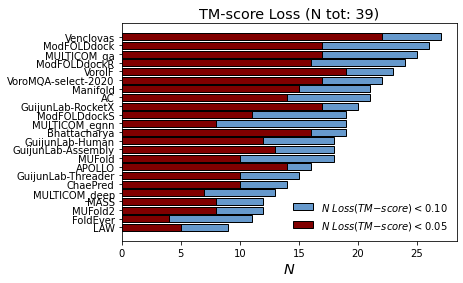

In [20]:
# do SCORE loss plot

thresh = 0.1
sub_df = tm_per_target_df[[col for col in tm_per_target_df.columns if "loss" in col]]
loss_count = sub_df[sub_df < thresh].count()
loss_count.sort_values(inplace=True)

y = list(range(loss_count.size))
labels = [item for item in loss_count.index.array]
labels = [group_mappings[item.split('_')[0]] for item in labels]
plt.barh(y, loss_count.values, color=cblue, linewidth=1.0, edgecolor='k', label="$N\ Loss(TM\mathrm{-}score)<0.10$")
plt.yticks(y, labels)

# slab bars with even higher quality on top

thresh = 0.05
sub_df = tm_per_target_df[[col for col in tm_per_target_df.columns if "loss" in col]]
highq_loss_count = sub_df[sub_df < thresh].count()
highq_labels = [item for item in highq_loss_count.index.array]
highq_labels = [group_mappings[item.split('_')[0]] for item in highq_labels]
highq_loss_dict = {label:loss for label, loss in zip(highq_labels, highq_loss_count.array)}

highq_values = [highq_loss_dict[l] for l in labels]
plt.barh(y, highq_values, color=cred, linewidth=1.0, edgecolor='k', label="$N\ Loss(TM\mathrm{-}score)<0.05$")
plt.legend(frameon=False)
plt.title(f"TM-score Loss (N tot: {tm_per_target_df.shape[0]})", fontsize="x-large")
plt.xlabel("$N$", fontsize="x-large")
plt.savefig(os.path.join(plot_dir, f"global_TMscore_loss_ranking.png"), dpi=300, bbox_inches="tight")

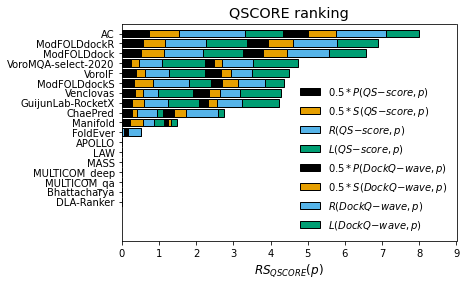

In [21]:
# do QSCORE plot

# apply the magic formula 
final_score_qs = 0.5*z_qs_per_group_df["pearson_r"] + 0.5*z_qs_per_group_df["spearman_r"] + z_qs_per_group_df["roc_auc"] + z_qs_per_group_df["loss"]
final_score_dockq = 0.5*z_dockq_per_group_df["pearson_r"] + 0.5*z_dockq_per_group_df["spearman_r"] + z_dockq_per_group_df["roc_auc"] + z_dockq_per_group_df["loss"]
final_score = np.add(final_score_qs, final_score_dockq)

# sort tables by final score
z_qs_per_group_df["final_score"] = final_score
z_dockq_per_group_df["final_score"] = final_score
z_qs_per_group_df.sort_values("final_score", inplace=True)
z_dockq_per_group_df.sort_values("final_score", inplace=True)


# stolen from http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plt.clf()
y = list(range(z_qs_per_group_df.shape[0]))

left = np.array([0] * len(y))
plt.barh(y, 0.5*z_qs_per_group_df["pearson_r"], left=left, color=colors[0], linewidth=1.0, edgecolor='k', label="$0.5*P(QS\mathrm{-}score,p)$")

left = np.add(left, 0.5*z_qs_per_group_df["pearson_r"])
plt.barh(y, 0.5*z_qs_per_group_df["spearman_r"], left=left, color=colors[1], linewidth=1.0, edgecolor='k', label="$0.5*S(QS\mathrm{-}score,p)$")

left = np.add(left, 0.5*z_qs_per_group_df["spearman_r"])
plt.barh(y, z_qs_per_group_df["roc_auc"], left=left, color=colors[2], linewidth=1.0, edgecolor='k', label="$R(QS\mathrm{-}score,p)$")

left = np.add(left, z_qs_per_group_df["roc_auc"])
plt.barh(y, z_qs_per_group_df["loss"], left=left, color=colors[3], linewidth=1.0, edgecolor='k', label="$L(QS\mathrm{-}score,p)$")

left = np.add(left, z_qs_per_group_df["loss"])
plt.barh(y, 0.5*z_dockq_per_group_df["pearson_r"], left=left, color=colors[0], linewidth=1.0, edgecolor='k', label="$0.5*P(DockQ\mathrm{-}wave,p)$")

left = np.add(left, 0.5*z_dockq_per_group_df["pearson_r"])
plt.barh(y, 0.5*z_dockq_per_group_df["spearman_r"], left=left, color=colors[1], linewidth=1.0, edgecolor='k', label="$0.5*S(DockQ\mathrm{-}wave,p)$")

left = np.add(left, 0.5*z_dockq_per_group_df["spearman_r"])
plt.barh(y, z_dockq_per_group_df["roc_auc"], left=left, color=colors[2], linewidth=1.0, edgecolor='k', label="$R(DockQ\mathrm{-}wave,p)$")

left = np.add(left, z_dockq_per_group_df["roc_auc"])
plt.barh(y, z_dockq_per_group_df["loss"], left=left, color=colors[3], linewidth=1.0, edgecolor='k', label="$L(DockQ\mathrm{-}wave,p)$")


plt.title("QSCORE ranking", fontsize="x-large")
plt.yticks(y, [group_mappings[x] for x in z_qs_per_group_df["group"]])
plt.xlabel("$RS_{QSCORE}(p)$", fontsize = "large")
plt.xlim((0,9))
plt.ylim((-4, 18))
plt.legend(frameon=False)

plt.savefig(os.path.join(plot_dir, f"global_QSCORE_zscore_ranking.png"), dpi=300, bbox_inches="tight")

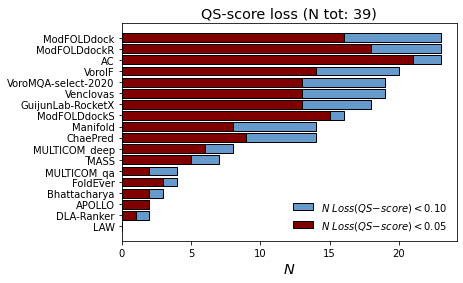

In [22]:
# do QSCORE loss plot

thresh = 0.1
sub_df = qs_per_target_df[[col for col in qs_per_target_df.columns if "loss" in col]]
loss_count = sub_df[sub_df < thresh].count()
loss_count.sort_values(inplace=True)

y = list(range(loss_count.size))
labels = [item for item in loss_count.index.array]
labels = [group_mappings[item.split('_')[0]] for item in labels]
plt.barh(y, loss_count.values, color=cblue, linewidth=1.0, edgecolor='k', label="$N\ Loss(QS\mathrm{-}score)<0.10$")
plt.yticks(y, labels)

# slab bars with even higher quality on top

thresh = 0.05
sub_df = qs_per_target_df[[col for col in qs_per_target_df.columns if "loss" in col]]
highq_loss_count = sub_df[sub_df < thresh].count()
highq_labels = [item for item in highq_loss_count.index.array]
highq_labels = [group_mappings[item.split('_')[0]] for item in highq_labels]
highq_loss_dict = {label:loss for label, loss in zip(highq_labels, highq_loss_count.array)}

highq_values = [highq_loss_dict[l] for l in labels]
plt.barh(y, highq_values, color=cred, linewidth=1.0, edgecolor='k', label="$N\ Loss(QS\mathrm{-}score)<0.05$")
plt.legend(frameon=False)
plt.title(f"QS-score loss (N tot: {qs_per_target_df.shape[0]})", fontsize="x-large")
plt.xlabel("$N$", fontsize="x-large")

plt.savefig(os.path.join(plot_dir, f"global_QS-best_loss_ranking.png"), dpi=300, bbox_inches="tight")

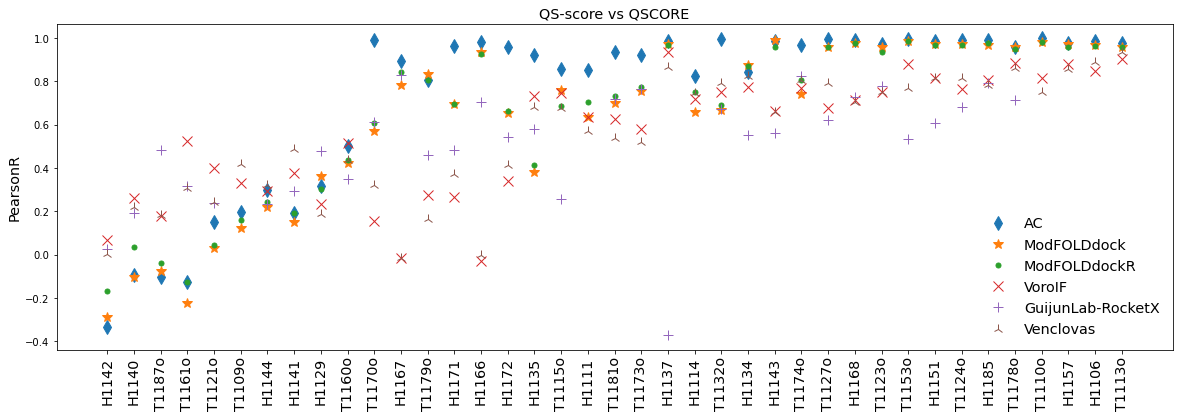

In [23]:
# Plot per-target evaluation for top performing groups
table_path = "../data/tables/QSCORE_tables/QS-best_per_target.csv"
#awesome_groups = ["086", "AC", "041", "266", "121", "089", "494"]
#awesome_groups_mapping = {"086": "MULTICOM_qa",
#                          "AC": "AC",
#                          "041": "ModFOLDdock",
#                          "266": "ModFOLDdockR",
#                          "121": "VoroIF",
#                          "089": "GuijunLab-RocketX",
#                          "494": "Venclovas"}

awesome_groups = ["AC", "041", "266", "121", "089", "494"]
awesome_groups_mapping = {"AC": "AC",
                          "041": "ModFOLDdock",
                          "266": "ModFOLDdockR",
                          "121": "VoroIF",
                          "089": "GuijunLab-RocketX",
                          "494": "Venclovas"}

table = pd.read_csv(table_path) 
group_cols = [f"{g}_pearson_r" for g in awesome_groups]
cols = ["trg"] + group_cols
table = table[cols]
table['mean'] = table[group_cols].mean(axis=1)
table.sort_values('mean', inplace=True)
table["idx"] = list(range(table.shape[0]))

plt.clf()
plt.gcf().set_figheight(6)
plt.gcf().set_figwidth(20)

marker_shapes = ['d', '*', '.', 'x', '+', '2']

for g, ms in zip(awesome_groups, marker_shapes):
    plt.plot("idx", f"{g}_pearson_r", ms, markersize=10, data=table, label=awesome_groups_mapping[g])
    
plt.legend(frameon=False, fontsize="x-large")
plt.ylabel("PearsonR", fontsize="x-large")
plt.xticks(table["idx"], table["trg"],rotation=90,fontsize="x-large")
plt.title("QS-score vs QSCORE", fontsize="x-large")
plt.savefig(os.path.join(plot_dir, f"per_target_pearson_qs.png"), dpi=300, bbox_inches="tight")

      trg  086_loss  AC_loss  041_loss  266_loss  121_loss  089_loss  \
16  H1140     0.900    0.900     0.900     0.900     0.000     0.900   
17  H1141     0.909    0.824     0.805     0.805     0.888     0.055   
18  H1142     0.673    0.673     0.673     0.673     0.673     0.673   
19  H1143     0.024    0.020     0.026     0.014     0.009     0.020   
20  H1144     0.949    0.791     0.791     0.791     0.804     0.000   

    494_loss  idx  
16     0.000    0  
17     0.034    1  
18     0.673    2  
19     0.000    3  
20     0.086    4  


([<matplotlib.axis.XTick at 0x7fdc30b4f1f0>,
 [Text(0, 0, 'H1140'),
  Text(1, 0, 'H1141'),
  Text(2, 0, 'H1142'),
  Text(3, 0, 'H1143'),
  Text(4, 0, 'H1144')])

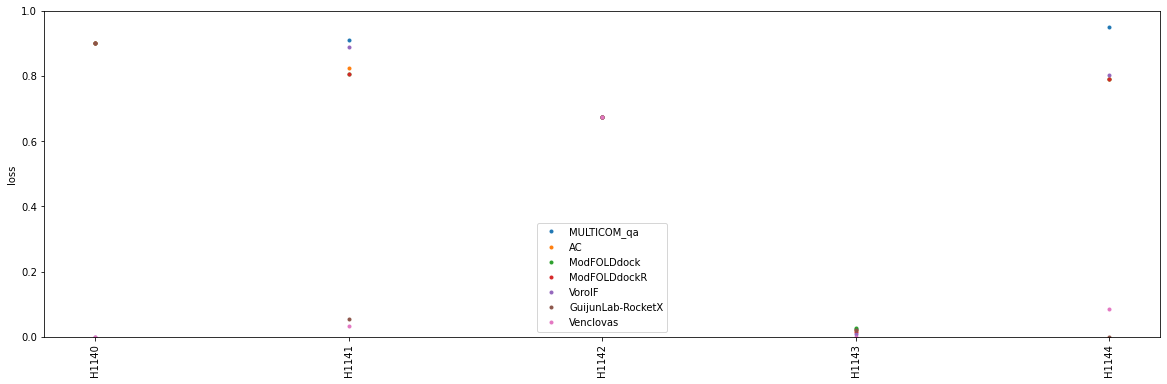

In [24]:
# Plot per-target evaluation for top performing groups
table_path = "../data/tables/QSCORE_tables/QS-best_per_target.csv"
metric = "loss"
awesome_groups = ["086", "AC", "041", "266", "121", "089", "494"]
awesome_groups_mapping = {"086": "MULTICOM_qa",
                          "AC": "AC",
                          "041": "ModFOLDdock",
                          "266": "ModFOLDdockR",
                          "121": "VoroIF",
                          "089": "GuijunLab-RocketX",
                          "494": "Venclovas"}

nanobodies = ["H1140", "H1141", "H1142", "H1143", "H1144"]
antibodies = ["H1166", "H1167", "H1168"]
target_selection = nanobodies

table = pd.read_csv(table_path) 
group_cols = [f"{g}_{metric}" for g in awesome_groups]
cols = ["trg"] + group_cols
table = table[cols]

table = table[table["trg"].str.contains('|'.join(nanobodies))]

#sel = [table["trg"].str.contains(x) for x in target_selection]
#print(sel)

#table = table[sel]

#table['mean'] = table[group_cols].mean(axis=1)
#table.sort_values('mean', inplace=True)
table["idx"] = list(range(table.shape[0]))

print(table)

plt.clf()
plt.gcf().set_figheight(6)
plt.gcf().set_figwidth(20)

plt.ylim((0.0,1.0))

for g in awesome_groups:
    plt.plot("idx", f"{g}_{metric}", '.', data=table, label=awesome_groups_mapping[g])
plt.legend()
plt.ylabel(metric)
plt.xticks(table["idx"], table["trg"],rotation=90)

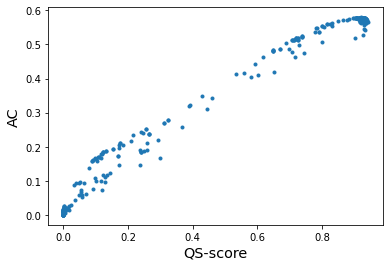

In [25]:
sub_df = df[df["trg"]=="H1143.pdb"]
plt.clf()
plt.plot("qs_best", "AC_QSCORE", '.', data=sub_df)
plt.ylabel("AC", fontsize="x-large")
plt.xlabel("QS-score", fontsize="x-large")
#sub_sub_df = sub_df[sub_df["AC_SCORE"] > 0.5]
#for mdl, ac_score in zip(sub_sub_df["mdl"], sub_sub_df["AC_SCORE"]):
#    print(mdl, ac_score)
plt.savefig(os.path.join(plot_dir, f"ac_vs_qs_H1143.png"), dpi=300, bbox_inches="tight")

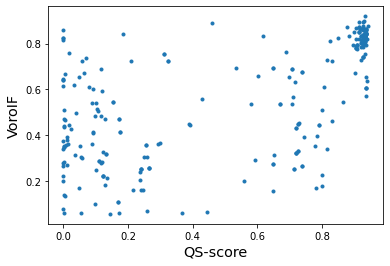

In [26]:
sub_df = df[df["trg"]=="H1143.pdb"]
plt.clf()
plt.plot("qs_best", "121_QSCORE", '.', data=sub_df)
plt.ylabel("VoroIF", fontsize="x-large")
plt.xlabel("QS-score", fontsize="x-large")
#sub_sub_df = sub_df[sub_df["AC_SCORE"] > 0.5]
#for mdl, ac_score in zip(sub_sub_df["mdl"], sub_sub_df["AC_SCORE"]):
#    print(mdl, ac_score)
plt.savefig(os.path.join(plot_dir, f"voroif_vs_qs_H1143.png"), dpi=300, bbox_inches="tight")

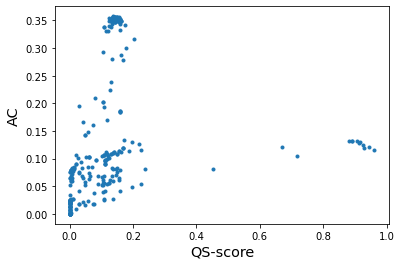

In [27]:
sub_df = df[df["trg"]=="H1141.pdb"]
plt.clf()
plt.plot("qs_best", "AC_QSCORE", '.', data=sub_df)
plt.ylabel("AC", fontsize="x-large")
plt.xlabel("QS-score", fontsize="x-large")
#sub_sub_df = sub_df[sub_df["AC_SCORE"] > 0.5]
#for mdl, ac_score in zip(sub_sub_df["mdl"], sub_sub_df["AC_SCORE"]):
#    print(mdl, ac_score)
plt.savefig(os.path.join(plot_dir, f"ac_vs_qs_H1141.png"), dpi=300, bbox_inches="tight")

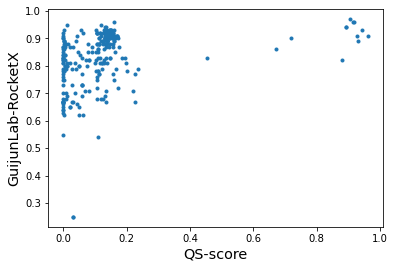

In [28]:
sub_df = df[df["trg"]=="H1141.pdb"]
plt.clf()
plt.plot("qs_best", "089_QSCORE", '.', data=sub_df)
plt.ylabel("GuijunLab-RocketX", fontsize="x-large")
plt.xlabel("QS-score", fontsize="x-large")
#sub_sub_df = sub_df[sub_df["AC_SCORE"] > 0.5]
#for mdl, ac_score in zip(sub_sub_df["mdl"], sub_sub_df["AC_SCORE"]):
#    print(mdl, ac_score)
plt.savefig(os.path.join(plot_dir, f"rocketx_vs_qs_H1141.png"), dpi=300, bbox_inches="tight")

      Unnamed: 0            mdl         trg  qs_best  dockq_wave  tm_score  \
1904        1904  T1121TS298_1o  T1121o.pdb    0.306       0.156   0.54283   
1838        1838  T1121TS390_2o  T1121o.pdb    0.303       0.157   0.54943   
1895        1895  T1121TS320_2o  T1121o.pdb    0.303       0.157   0.54943   
1912        1912  T1121TS312_4o  T1121o.pdb    0.320       0.149   0.54497   
1736        1736  T1121TS003_3o  T1121o.pdb    0.305       0.156   0.54341   
1943        1943  T1121TS298_2o  T1121o.pdb    0.304       0.156   0.54381   
1754        1754  T1121TS054_2o  T1121o.pdb    0.302       0.154   0.55386   
1789        1789  T1121TS125_2o  T1121o.pdb    0.302       0.154   0.55386   
1861        1861  T1121TS399_2o  T1121o.pdb    0.302       0.154   0.55386   
1869        1869  T1121TS298_4o  T1121o.pdb    0.305       0.156   0.54589   
1926        1926  T1121TS248_2o  T1121o.pdb    0.306       0.156   0.54377   
1813        1813  T1121TS035_2o  T1121o.pdb    0.306       0.156

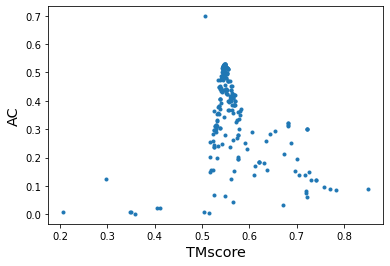

In [29]:
sub_df = df[df["trg"]=="T1121o.pdb"]
plt.clf()
plt.plot("tm_score", "AC_SCORE", '.', data=sub_df)
plt.ylabel("AC", fontsize="x-large")
plt.xlabel("TMscore", fontsize="x-large")
#sub_sub_df = sub_df[sub_df["AC_SCORE"] > 0.5]
#for mdl, ac_score in zip(sub_sub_df["mdl"], sub_sub_df["AC_SCORE"]):
#    print(mdl, ac_score)
#plt.savefig(os.path.join(plot_dir, f"ac_vs_qs_H1141.png"), dpi=300, bbox_inches="tight")
yolo = sub_df[sub_df["AC_SCORE"]>0.5]
yolo = yolo.sort_values("AC_SCORE")
print(yolo)

In [30]:

own_models = 0
for trg, trg_file in target_data.items():
    sub_df = df[df["trg"] == trg_file]
    # skip targets that have been filtered out completely in preprocessing (happens for T1192o)
    if sub_df.shape[0] == 0:
        print(f"no data for {trg}... skip...")
        continue
    # per-target evaluation only assesses targets which fulfill very crude
    # quality filter, e.g. max TMscore of any of the models > 0.6
    if sub_df["tm_score"].max() < 0.6:
        print("skip trg", trg)
        continue

    selected_idx = sub_df["494_SCORE"].idxmax()
    if "TS494" in sub_df["mdl"][selected_idx]:
        own_models += 1
    print(trg, sub_df["mdl"][selected_idx])
print(own_models)

H1106 H1106TS278_4
T1109o T1109TS037_4o
T1110o T1110TS462_5o
H1111 H1111TS494_2
T1113o T1113TS462_2o
H1114 H1114TS439_4
T1115o T1115TS494_1o
T1121o T1121TS169_2o
T1123o T1123TS187_2o
T1124o T1124TS131_2o
T1127o T1127TS347_3o
H1129 H1129TS439_1
T1132o T1132TS399_2o
H1134 H1134TS278_1
H1135 H1135TS348_2
H1137 H1137TS444_4
H1140 H1140TS037_1
H1141 H1141TS374_2
H1142 H1142TS494_1
H1143 H1143TS225_2
H1144 H1144TS494_1
H1151 H1151TS011_4
T1153o T1153TS461_1o
H1157 H1157TS188_3
T1160o T1160TS367_1o
T1161o T1161TS446_3o
H1166 H1166TS125_1
H1167 H1167TS278_1
H1168 H1168TS399_2
T1170o T1170TS205_1o
H1171 H1171TS205_3
H1172 H1172TS205_3
T1173o T1173TS119_1o
T1174o T1174TS248_3o
skip trg T1176o
T1178o T1178TS288_1o
T1179o T1179TS439_1o
T1181o T1181TS320_1o
H1185 H1185TS125_3
T1187o T1187TS494_1o
no data for T1192o... skip...
5


<AxesSubplot:xlabel='tm_score', ylabel='gdtts'>

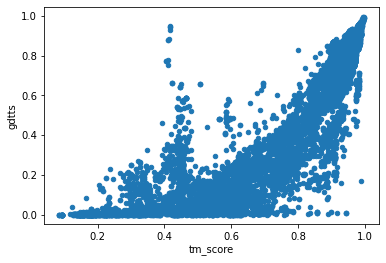

In [31]:
df.plot.scatter("tm_score", "gdtts")
#print(df["266_QSCORE"].corr(df["TMscore"]))
#print(len(df[df["266_QSCORE"].isnull() == False]))

0.4227433680027404


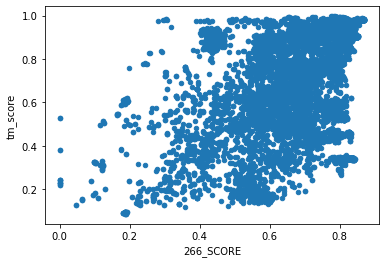

In [32]:
df.plot.scatter("266_SCORE", "tm_score")
print(df["266_SCORE"].corr(df["tm_score"]))

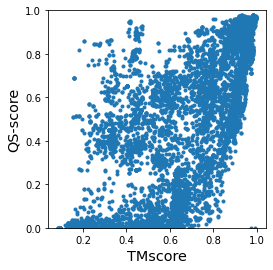

In [33]:
plt.clf()
plt.scatter('tm_score', 'qs_best', data=df, marker='.')
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("TMscore", fontsize="x-large")
plt.ylabel("QS-score", fontsize="x-large")
plt.savefig(os.path.join("../data/figures_for_pres", "tm_vs_qs.png"), dpi=300)

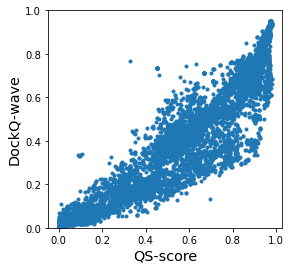

In [34]:
plt.clf()
plt.scatter('qs_best', 'dockq_wave', data=df, marker='.')
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("QS-score", fontsize="x-large")
plt.ylabel("DockQ-wave", fontsize="x-large")
plt.savefig(os.path.join("../data/figures_for_pres", "qs_vs_dockq.png"), dpi=300)

Text(0, 0.5, 'Venclovas')

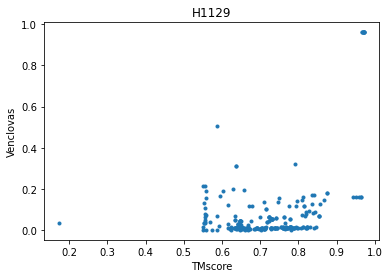

In [35]:
sub_df = df[(df["trg"]=="H1129.pdb")]
plt.scatter('tm_score', '494_SCORE', data=sub_df, marker='.')
plt.title("H1129")
plt.xlabel("TMscore")
plt.ylabel("Venclovas")

T1121TS165_4o 0.2073 0.0096057286317471
T1121TS494_3o 0.29619 0.1245540691192865
T1121TS398_4o 0.34857 0.0076129750085587
T1121TS234_1o 0.35066 0.0095401118338468
T1121TS314_4o 0.35892 0.0014863631176537
T1121TS314_5o 0.40543 0.0233267716535433
T1121TS314_3o 0.41128 0.0234908136482939
T1121TS131_4o 0.50448 0.0072520826201072
T1121TS494_2o 0.50659 0.6983049714896649
T1121TS098_4o 0.51477 0.0037829510441629
T1121TS185_1o 0.51664 0.2018272851763095
T1121TS278_2o 0.51711 0.1489287344516718
T1121TS147_3o 0.51727 0.2563990642474038
T1121TS385_1o 0.51895 0.1566215907794134
T1121TS374_3o 0.52246 0.2584574346684925
T1121TS205_4o 0.52367 0.1563377268058883
T1121TS374_2o 0.52422 0.2816358553006961
T1121TS248_4o 0.52431 0.2363231769941801
T1121TS035_4o 0.52431 0.2363231769941801
T1121TS131_1o 0.52482 0.2976492068926167
T1121TS119_1o 0.52482 0.2976591920575145
T1121TS398_1o 0.52515 0.3639949218304233
T1121TS374_1o 0.52565 0.2446365399977176
T1121TS239_3o 0.52617 0.0680075316672372
T1121TS248_1o 0.5

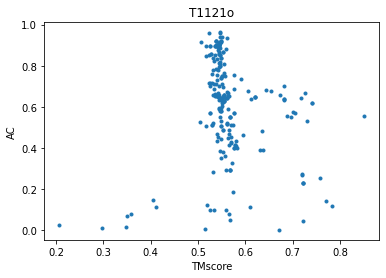

In [36]:
sub_df = df[(df["trg"]=="T1121o.pdb")]
plt.scatter('tm_score', '121_SCORE', data=sub_df, marker='.')
plt.title("T1121o")
plt.xlabel("TMscore")
plt.ylabel("AC")
sub_df = sub_df.sort_values("tm_score")
for mdl, tm, pred in zip(sub_df["mdl"], sub_df["tm_score"], sub_df["AC_SCORE"]):
    print(mdl, tm, pred)

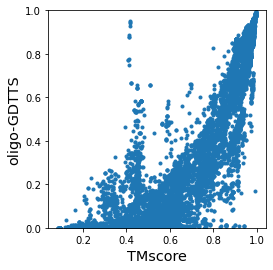

In [37]:
plt.clf()
plt.scatter('tm_score', 'gdtts', data=df, marker='.')
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("TMscore", fontsize="x-large")
plt.ylabel("oligo-GDTTS", fontsize="x-large")
plt.savefig(os.path.join("../data/figures_for_pres", "tm_vs_gdtts_scatter.png"), dpi=300)

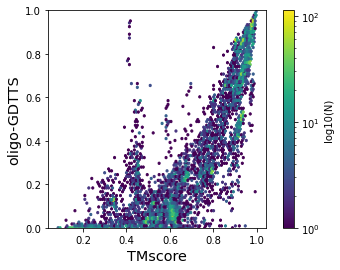

In [38]:
plt.clf()
plt.hexbin('tm_score', 'gdtts', data=df, bins="log")
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("TMscore", fontsize="x-large")
plt.ylabel("oligo-GDTTS", fontsize="x-large")
plt.colorbar(label="log10(N)")
plt.savefig(os.path.join("../data/figures_for_pres", "tm_vs_gdtts_hexbin.png"), dpi=300)

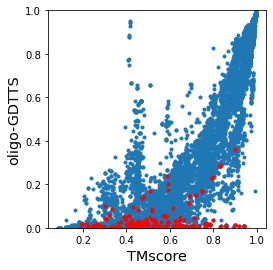

In [39]:
plt.clf()
plt.scatter('tm_score', 'gdtts', data=df, marker='.')
plt.scatter('tm_score', 'gdtts', data=df[df["trg"]=="H1135.pdb"], marker='.', color='r')
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("TMscore", fontsize="x-large")
plt.ylabel("oligo-GDTTS", fontsize="x-large")
plt.savefig(os.path.join("../data/figures_for_pres", "tm_vs_gdtts_scatter_with_H1135.png"), dpi=300)

In [40]:
yolo = df[(df["tm_score"]<0.5) & (df["gdtts"]>0.3)]["trg"].unique()
print(yolo.shape)
print(yolo)

(5,)
['T1160o.pdb' 'T1161o.pdb' 'T1173o.pdb' 'T1174o.pdb' 'T1181o.pdb']


In [41]:
sub_df = df[df["mdl"]=="H1114TS348_2"]
sub_df.head()

Unnamed: 0           mdl        trg  qs_best  dockq_wave  tm_score  \
1425        1425  H1114TS348_2  H1114.pdb    0.775    0.740041   0.89015   

      gdtts  n_mdl_chains  398_SCORE  398_QSCORE  ...  468_QSCORE  168_SCORE  \
1425  0.002          20.0      0.961       0.961  ...         NaN        NaN   

      168_QSCORE  298_SCORE  298_QSCORE  098_SCORE  098_QSCORE  AC_SCORE  \
1425         NaN     0.5614         NaN     0.7054         NaN  0.024687   

      AC_QSCORE  n_trg_chains  
1425   0.491758            20  

[1 rows x 63 columns]

In [42]:
sub_df = df[df["trg"]=="H1114.pdb"]
print(sub_df["tm_score"].corr(sub_df["gdtts"], method="spearman"))

0.8947472185230384


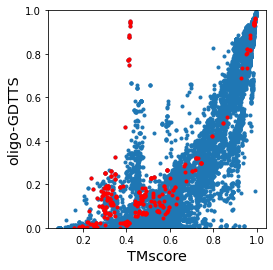

In [43]:
plt.clf()
plt.scatter('tm_score', 'gdtts', data=df, marker='.')
plt.scatter('tm_score', 'gdtts', data=df[df["trg"]=="T1173o.pdb"], marker='.', color='r')
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("TMscore", fontsize="x-large")
plt.ylabel("oligo-GDTTS", fontsize="x-large")
plt.savefig(os.path.join("../data/figures_for_pres", "tm_vs_gdtts_scatter_with_T1173o.png"), dpi=300)

0.7067455922687621


Text(0, 0.5, '086_SCORE')

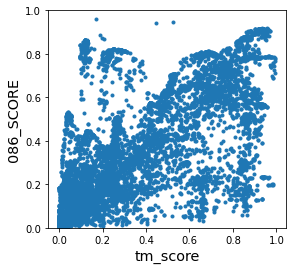

In [44]:
plt.clf()
plt.scatter('gdtts', 'AC_SCORE', data=df, marker='.')
print(df["gdtts"].corr(df["AC_SCORE"]))
plt.ylim((0,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("tm_score", fontsize="x-large")
plt.ylabel("086_SCORE", fontsize="x-large")
#plt.savefig(os.path.join("../data/figures_for_pres", "tm_vs_086_SCORE_scatter.png"), dpi=300)

In [45]:
awesome_groups = ["086", "AC", "041", "266", "121", "089"]

per_target_rocauc_scores_tmscores = {g: list() for g in awesome_groups}
per_target_rocauc_scores_gdt = {g: list() for g in awesome_groups}
per_target_rocauc_qscores_qs = {g: list() for g in awesome_groups}
per_target_rocauc_qscores_dockq = {g: list() for g in awesome_groups}

trg_files = list()
for trg, trg_file in target_data.items():
    sub_df = df[df["trg"] == trg_file]
    if sub_df["tm_score"].max() > 0.6:
        trg_files.append(trg_file)
    else:
        print("skip trg", trg)
        
for t in trg_files:
    print("process target", t)
    sub_df = df[df["trg"] == t]
    for g in awesome_groups:
        print(g)
        # do SCORE
        n_exp = sub_df.shape[0]
        n_pred = sub_df[sub_df[g+"_SCORE"].isnull()==False].shape[0]
        if float(n_pred)/n_exp < 0.8:
            print("skip group",g)
            per_target_rocauc_scores_tmscores[g].append(None)
        else:
            per_target_rocauc_scores_tmscores[g].append(adaptive_rocauc(sub_df, "tm_score", g+"_SCORE"))
        # do QSCORE
        n_exp = sub_df.shape[0]
        n_pred = sub_df[sub_df[g+"_QSCORE"].isnull()==False].shape[0]
        if float(n_pred)/n_exp < 0.8:
            print("skip group",g)
            per_target_rocauc_qscores_qs[g].append(None)
        else:
            per_target_rocauc_qscores_qs[g].append(adaptive_rocauc(sub_df, "qs_best", g+"_QSCORE"))
        


skip trg T1176o
skip trg T1192o
process target H1106.pdb
086
AC
041
266
121
089
skip group 089
skip group 089
process target T1109o.pdb
086
AC
041
266
121
089
skip group 089
process target T1110o.pdb
086
AC
041
266
121
089
skip group 089
process target H1111.pdb
086
AC
041
266
121
089
skip group 089
process target T1113o.pdb
086
AC
041
266
121
089
skip group 089
process target H1114.pdb
086
AC
041
266
121
089
skip group 089
process target T1115o.pdb
086
AC
041
266
121
089
process target T1121o.pdb
086
AC
041
266
121
089
process target T1123o.pdb
086
AC
041
266
121
089
process target T1124o.pdb
086
AC
041
266
121
089
process target T1127o.pdb
086
AC
041
266
121
089
process target H1129.pdb
086
AC
041
266
121
089
process target T1132o.pdb
086
AC
041
266
121
089
process target H1134.pdb
086
AC
041
266
121
089
process target H1135.pdb
086
AC
041
266
121
089
process target H1137.pdb
086
AC
041
266
121
089
process target H1140.pdb
086
AC
041
266
121
089
process target H1141.pdb
086
AC
041
26

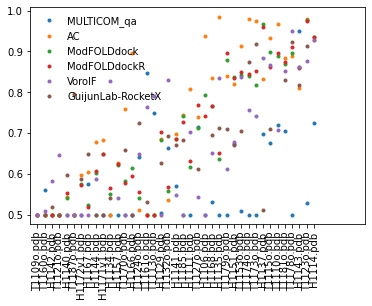

In [46]:
plt.clf()
plt.rcParams["figure.figsize"] = (20,6)

avg_values = list()
for s_idx in range(len(trg_files)):
    scores = list()
    for g in awesome_groups:
        score = per_target_rocauc_qscores_qs[g][s_idx]
        if score is not None:
            scores.append(score)
    avg_values.append(np.mean(scores))
tmp = [(a,b) for a,b in zip(avg_values, range(len(trg_files)))]
tmp.sort()
sorted_trg_files = [trg_files[x[1]] for x in tmp]
for g in awesome_groups:
    sorted_values = [per_target_rocauc_qscores_qs[g][x[1]] for x in tmp]
    per_target_rocauc_qscores_qs[g] = sorted_values


for g in awesome_groups:
    x = list()
    y = list()
    for s_idx, s in enumerate(per_target_rocauc_qscores_qs[g]):
        if s is not None:
            x.append(s_idx)
            y.append(s)
    plt.plot(x,y,'.',label=group_mappings[g])
plt.xlim((-1, 45))
plt.legend(frameon=False)
plt.xticks(range(len(sorted_trg_files)), sorted_trg_files, rotation=90)

plt.show()

<AxesSubplot:>

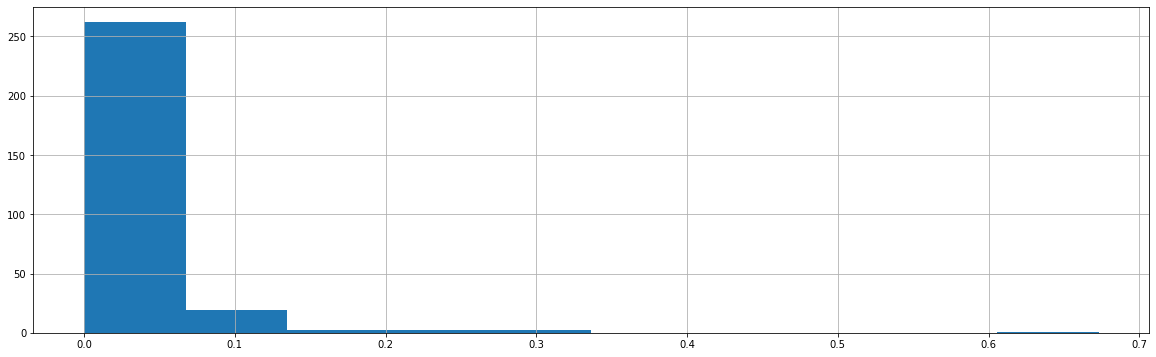

In [47]:
df[df["trg"]=="H1142.pdb"]["qs_best"].hist()

In [48]:
print(df["qs_best"].idxmax())

6048


In [49]:

H1142_df = df[df["trg"]=="H1142.pdb"]
best_score = H1142_df["qs_best"].max()
selected_score = H1142_df["qs_best"][H1142_df["121_QSCORE"].idxmax()]
print(best_score)
print(selected_score)

0.673
0.0


<AxesSubplot:ylabel='Frequency'>

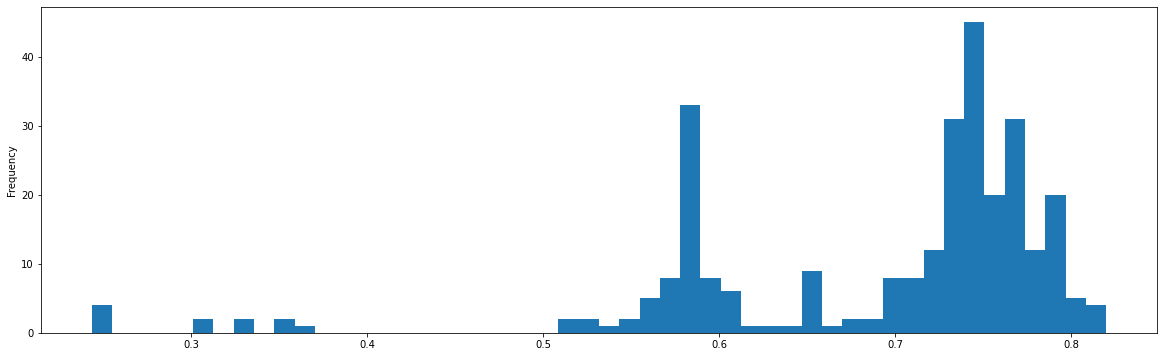

In [50]:
sub_df = df[df["trg"]=="H1166.pdb"]
sub_df["tm_score"].plot.hist(bins = 50)

[0.22825, 0.22825, 0.22825, 0.22825, 0.28915, 0.28915, 0.30498, 0.30498, 0.35624, 0.35624, 0.40767, 0.4155, 0.41971, 0.42352, 0.45082, 0.49504, 0.50068, 0.50566, 0.51055, 0.51564, 0.516, 0.51849, 0.51917, 0.51917, 0.51943, 0.51949, 0.51949, 0.51975, 0.51975, 0.52057, 0.52057, 0.52106, 0.52106, 0.52106, 0.52106, 0.52123, 0.52123, 0.52123, 0.52123, 0.52126, 0.52126, 0.52126, 0.52146, 0.52146, 0.52202, 0.52202, 0.52211, 0.52211, 0.52237, 0.52237, 0.52273, 0.52282, 0.52282, 0.52292, 0.52294, 0.5231, 0.52318, 0.52333, 0.52333, 0.52348, 0.52368, 0.52377, 0.52384, 0.52384, 0.52397, 0.52397, 0.52411, 0.52414, 0.52414, 0.52422, 0.52422, 0.52422, 0.52429, 0.52436, 0.52461, 0.52463, 0.52463, 0.52469, 0.52469, 0.525, 0.52525, 0.52538, 0.52538, 0.52553, 0.52553, 0.52586, 0.52594, 0.52594, 0.52594, 0.52605, 0.52605, 0.52605, 0.52611, 0.52618, 0.5264, 0.52642, 0.52652, 0.52652, 0.52686, 0.5272, 0.52736, 0.52736, 0.52736, 0.52799, 0.52799, 0.52807, 0.52807, 0.52807, 0.52846, 0.52902, 0.52904, 0.52911,

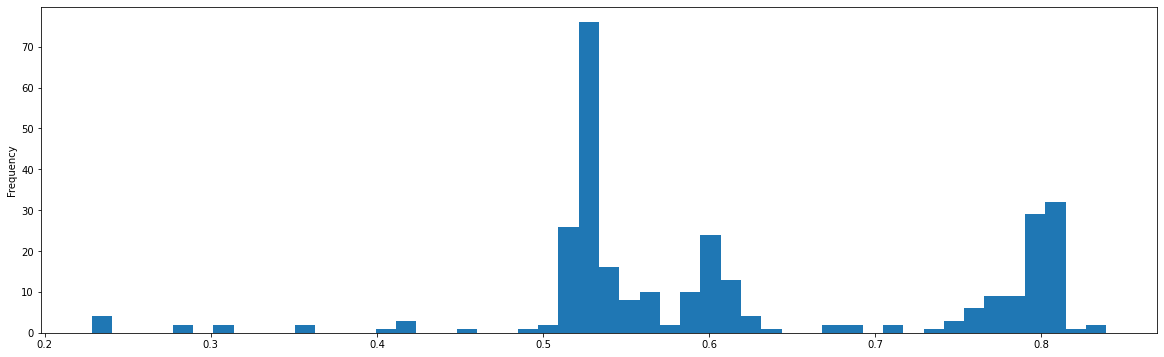

In [69]:
sub_df = df[df["trg"]=="H1167.pdb"]
sub_df["tm_score"].plot.hist(bins=50)
print(sorted(sub_df["tm_score"]))

<AxesSubplot:ylabel='Frequency'>

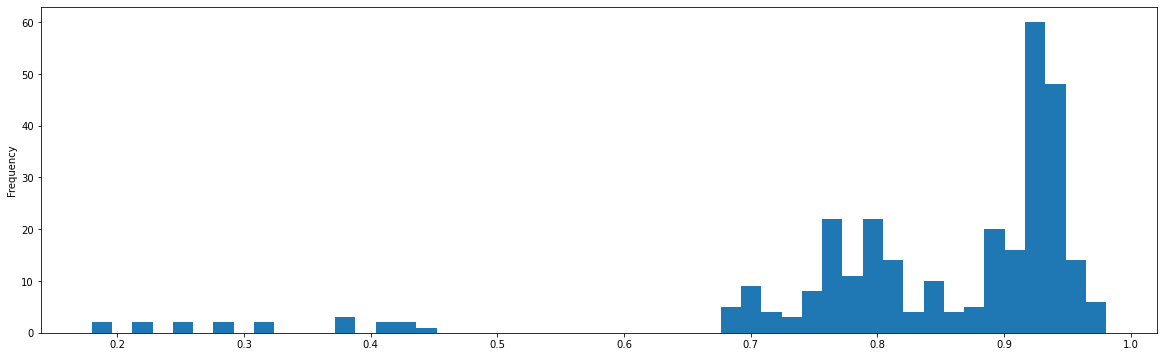

In [62]:
sub_df = df[df["trg"]=="H1168.pdb"]
sub_df["tm_score"].plot.hist(bins=50)

In [63]:
sub_df = df[df["trg"]=="H1140.pdb", bins=50]
sub_df["qs_best"].plot.hist()

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (3600289356.py, line 1)

<AxesSubplot:ylabel='Frequency'>

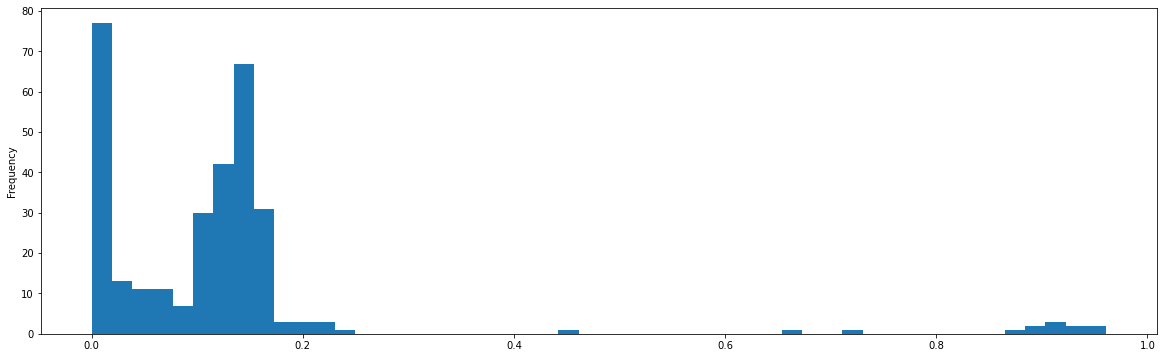

In [64]:
sub_df = df[df["trg"]=="H1141.pdb"]
sub_df["qs_best"].plot.hist(bins = 50)

<AxesSubplot:ylabel='Frequency'>

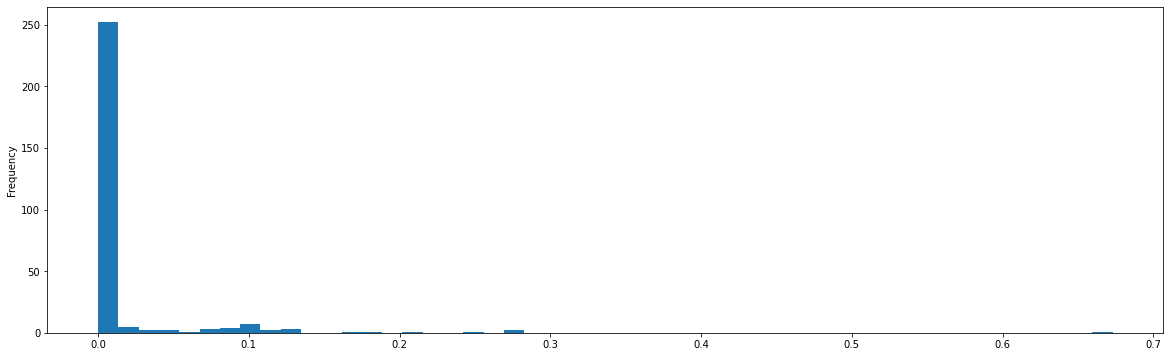

In [65]:
sub_df = df[df["trg"]=="H1142.pdb"]
sub_df["qs_best"].plot.hist(bins = 50)

<AxesSubplot:ylabel='Frequency'>

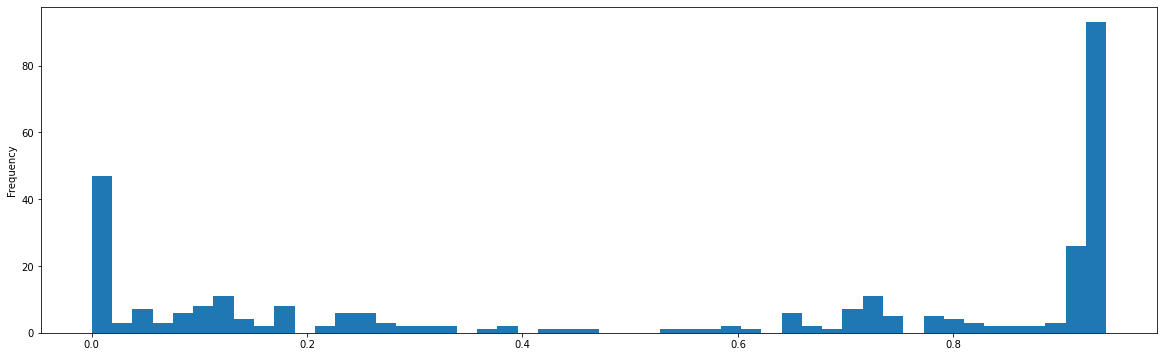

In [66]:
sub_df = df[df["trg"]=="H1143.pdb"]
sub_df["qs_best"].plot.hist(bins = 50)

<AxesSubplot:ylabel='Frequency'>

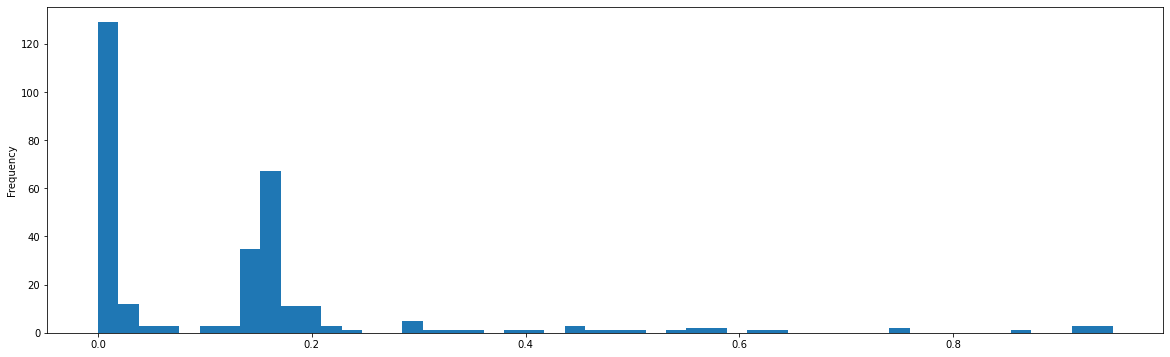

In [67]:
sub_df = df[df["trg"]=="H1144.pdb"]
sub_df["qs_best"].plot.hist(bins=50)

([<matplotlib.axis.YTick at 0x7fdc2e9e8b50>,
 [Text(0, 0, 'FoldEver'),
  Text(0, 1, 'APOLLO'),
  Text(0, 2, 'ChaePred'),
  Text(0, 3, 'MUFold'),
  Text(0, 4, 'MUFold2'),
  Text(0, 5, 'Bhattacharya'),
  Text(0, 6, 'LAW'),
  Text(0, 7, 'MULTICOM_egnn'),
  Text(0, 8, 'GuijunLab-Assembly'),
  Text(0, 9, 'GuijunLab-Human'),
  Text(0, 10, 'GuijunLab-RocketX'),
  Text(0, 11, 'MULTICOM_deep'),
  Text(0, 12, 'MASS'),
  Text(0, 13, 'AC'),
  Text(0, 14, 'VoroMQA-select-2020'),
  Text(0, 15, 'GuijunLab-Threader'),
  Text(0, 16, 'ModFOLDdockS'),
  Text(0, 17, 'MULTICOM_qa'),
  Text(0, 18, 'ModFOLDdockR'),
  Text(0, 19, 'ModFOLDdock'),
  Text(0, 20, 'Manifold'),
  Text(0, 21, 'Venclovas'),
  Text(0, 22, 'VoroIF')])

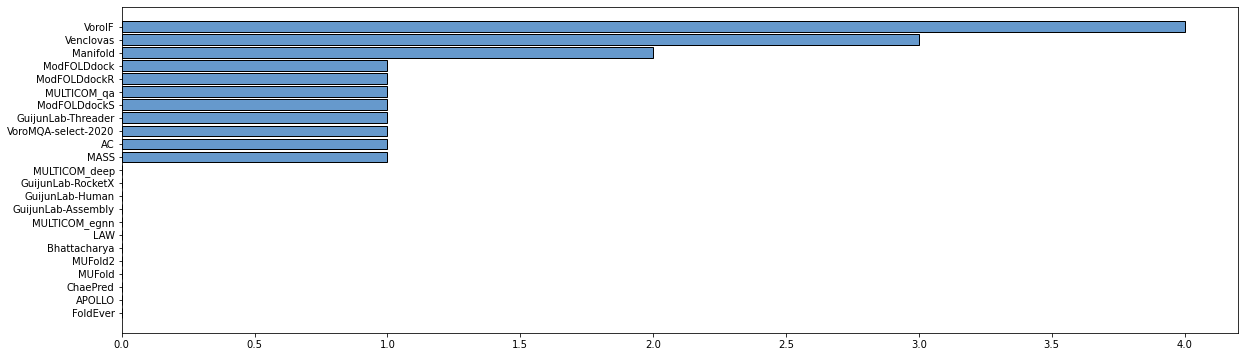

In [58]:
# do SCORE loss plot on nanobodies

thresh = 0.1
sub_df = tm_per_target_df[(tm_per_target_df["trg"]=="H1140") | (tm_per_target_df["trg"]=="H1141") | (tm_per_target_df["trg"]=="H1142") | (tm_per_target_df["trg"]=="H1143") | (tm_per_target_df["trg"]=="H1144")]
sub_df = sub_df[[col for col in sub_df.columns if "loss" in col]]
loss_count = sub_df[sub_df < thresh].count()
loss_count.sort_values(inplace=True)

y = list(range(loss_count.size))
labels = [item for item in loss_count.index.array]
labels = [group_mappings[item.split('_')[0]] for item in labels]
plt.barh(y, loss_count.values, color=cblue, linewidth=1.0, edgecolor='k', label="$N\ Loss(TM\mathrm{-}score)<0.10$")
plt.yticks(y, labels)



([<matplotlib.axis.YTick at 0x7fdc2eb8cd00>,
 [Text(0, 0, 'DLA-Ranker'),
  Text(0, 1, 'FoldEver'),
  Text(0, 2, 'ChaePred'),
  Text(0, 3, 'Bhattacharya'),
  Text(0, 4, 'APOLLO'),
  Text(0, 5, 'LAW'),
  Text(0, 6, 'MASS'),
  Text(0, 7, 'ModFOLDdockS'),
  Text(0, 8, 'MULTICOM_deep'),
  Text(0, 9, 'Manifold'),
  Text(0, 10, 'AC'),
  Text(0, 11, 'MULTICOM_qa'),
  Text(0, 12, 'ModFOLDdockR'),
  Text(0, 13, 'ModFOLDdock'),
  Text(0, 14, 'VoroIF'),
  Text(0, 15, 'GuijunLab-RocketX'),
  Text(0, 16, 'VoroMQA-select-2020'),
  Text(0, 17, 'Venclovas')])

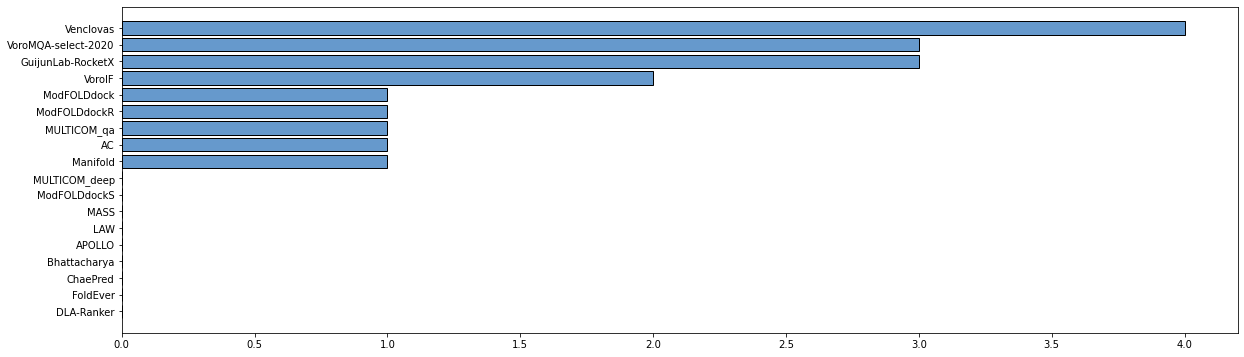

In [59]:
# do QSCORE loss plot on nanobodies

thresh = 0.1
sub_df = qs_per_target_df[(qs_per_target_df["trg"]=="H1140") | (qs_per_target_df["trg"]=="H1141") | (qs_per_target_df["trg"]=="H1142") | (qs_per_target_df["trg"]=="H1143") | (qs_per_target_df["trg"]=="H1144")]
sub_df = sub_df[[col for col in sub_df.columns if "loss" in col]]
loss_count = sub_df[sub_df < thresh].count()
loss_count.sort_values(inplace=True)

y = list(range(loss_count.size))
labels = [item for item in loss_count.index.array]
labels = [group_mappings[item.split('_')[0]] for item in labels]
plt.barh(y, loss_count.values, color=cblue, linewidth=1.0, edgecolor='k', label="$N\ Loss(TM\mathrm{-}score)<0.10$")
plt.yticks(y, labels)

([<matplotlib.axis.YTick at 0x7fdc2e91e440>,
 [Text(0, 0, 'APOLLO'),
  Text(0, 1, 'LAW'),
  Text(0, 2, 'MASS'),
  Text(0, 3, 'FoldEver'),
  Text(0, 4, 'ChaePred'),
  Text(0, 5, 'MUFold2'),
  Text(0, 6, 'Bhattacharya'),
  Text(0, 7, 'GuijunLab-Assembly'),
  Text(0, 8, 'GuijunLab-Human'),
  Text(0, 9, 'ModFOLDdockS'),
  Text(0, 10, 'GuijunLab-Threader'),
  Text(0, 11, 'GuijunLab-RocketX'),
  Text(0, 12, 'MULTICOM_deep'),
  Text(0, 13, 'AC'),
  Text(0, 14, 'VoroMQA-select-2020'),
  Text(0, 15, 'MULTICOM_qa'),
  Text(0, 16, 'MULTICOM_egnn'),
  Text(0, 17, 'VoroIF'),
  Text(0, 18, 'ModFOLDdockR'),
  Text(0, 19, 'MUFold'),
  Text(0, 20, 'Venclovas'),
  Text(0, 21, 'Manifold'),
  Text(0, 22, 'ModFOLDdock')])

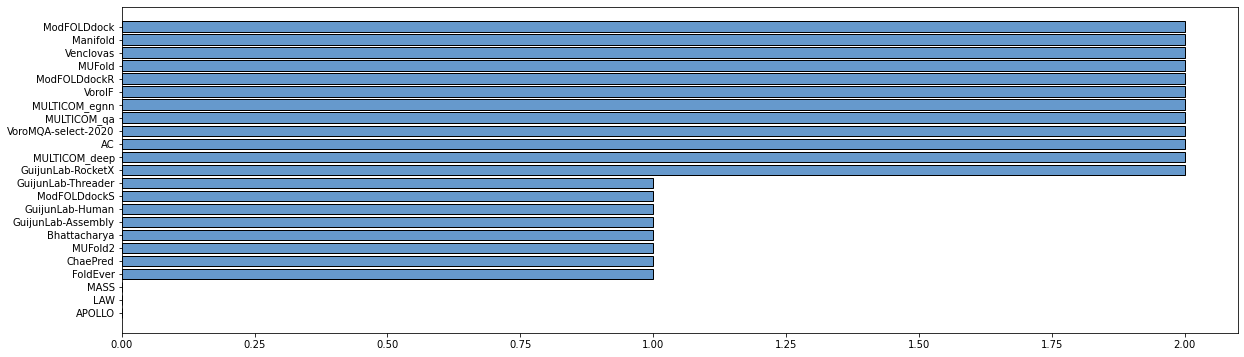

In [60]:
# do SCORE loss plot on antibodies

thresh = 0.1
sub_df = tm_per_target_df[(tm_per_target_df["trg"]=="H1166") | (tm_per_target_df["trg"]=="H1167") | (tm_per_target_df["trg"]=="H1168")]
sub_df = sub_df[[col for col in sub_df.columns if "loss" in col]]
loss_count = sub_df[sub_df < thresh].count()
loss_count.sort_values(inplace=True)

y = list(range(loss_count.size))
labels = [item for item in loss_count.index.array]
labels = [group_mappings[item.split('_')[0]] for item in labels]
plt.barh(y, loss_count.values, color=cblue, linewidth=1.0, edgecolor='k', label="$N\ Loss(TM\mathrm{-}score)<0.10$")
plt.yticks(y, labels)

([<matplotlib.axis.YTick at 0x7fdc30753520>,
 [Text(0, 0, 'DLA-Ranker'),
  Text(0, 1, 'ChaePred'),
  Text(0, 2, 'Bhattacharya'),
  Text(0, 3, 'VoroIF'),
  Text(0, 4, 'MULTICOM_qa'),
  Text(0, 5, 'Manifold'),
  Text(0, 6, 'MULTICOM_deep'),
  Text(0, 7, 'MASS'),
  Text(0, 8, 'LAW'),
  Text(0, 9, 'APOLLO'),
  Text(0, 10, 'FoldEver'),
  Text(0, 11, 'Venclovas'),
  Text(0, 12, 'ModFOLDdockR'),
  Text(0, 13, 'ModFOLDdockS'),
  Text(0, 14, 'GuijunLab-RocketX'),
  Text(0, 15, 'VoroMQA-select-2020'),
  Text(0, 16, 'AC'),
  Text(0, 17, 'ModFOLDdock')])

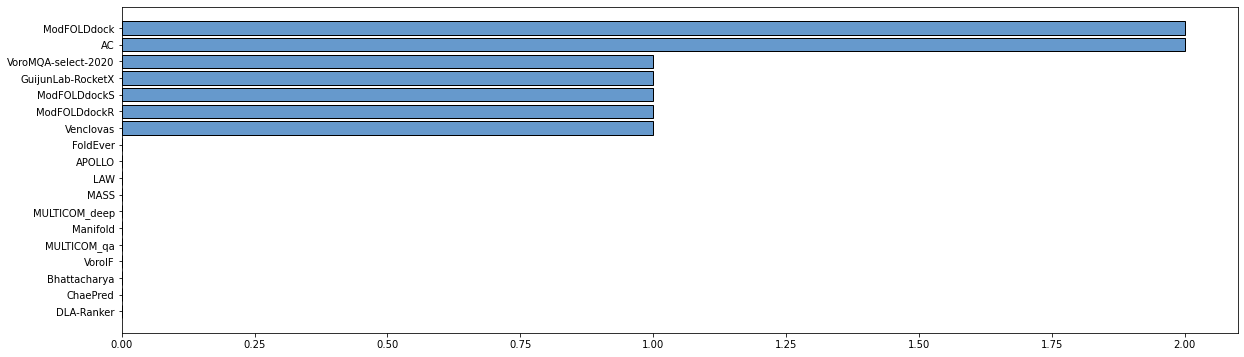

In [61]:
# do QSCORE loss plot on antibodies

thresh = 0.1
sub_df = qs_per_target_df[(qs_per_target_df["trg"]=="H1166") | (qs_per_target_df["trg"]=="H1167") | (qs_per_target_df["trg"]=="H1168")]
sub_df = sub_df[[col for col in sub_df.columns if "loss" in col]]
loss_count = sub_df[sub_df < thresh].count()
loss_count.sort_values(inplace=True)

y = list(range(loss_count.size))
labels = [item for item in loss_count.index.array]
labels = [group_mappings[item.split('_')[0]] for item in labels]
plt.barh(y, loss_count.values, color=cblue, linewidth=1.0, edgecolor='k', label="$N\ Loss(TM\mathrm{-}score)<0.10$")
plt.yticks(y, labels)